In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats


# Prepare loss function

In [2]:
def obstacle_penalty(observation, penalty_factor):
    """
    Calculates the value of probability density function of a bivariate normal distribution at a given point.
    Arguments:
    x, y : float
        Coordinates of the point at which to calculate the probability density value.
    mu_x, mu_y : float
        Mean values (expectations) along the X and Y axes, respectively.
    sigma_x, sigma_y : float
        Standard deviations along the X and Y axes, respectively.
    rho : float
        Correlation coefficient between X and Y.

    Returns:
    float
        Value of the probability density function of a bivariate normal distribution at the given point (x, y).
    """
    mu_x = obstacle_x = -0.5
    sigma_x = obstacle_sigma = 0.2

    mu_y = obstacle_y = -0.5
    sigma_y = obstacle_sigma = 0.2
    rho = 0
    x = observation[0]
    y = observation[1]
    z = ((x - mu_x) ** 2) / (sigma_x ** 2) + ((y - mu_y) ** 2) / (sigma_y ** 2) - (2 * rho * (x - mu_x) * (y - mu_y)) / (sigma_x * sigma_y)
    denom = 2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho ** 2)
    return np.exp(-z / (2 * (1 - rho ** 2))) / denom * penalty_factor

In [3]:
x_lim = y_lim = [-1, 0]
X = np.arange(x_lim[0], x_lim[1], 0.01)
Y = np.arange(y_lim[0], y_lim[1], 0.01)

X, Y = np.meshgrid(X, Y)
Z = []
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z.append(obstacle_penalty(observation=[X[i, j], Y[i, j]], penalty_factor=1e1))

Z = np.array(Z).reshape((X.shape[0], X.shape[1]))
# len(Z)

In [4]:
linestyle_dict = {
     'loosely dotted': (0, (1, 10)),
     'dotted': (0, (1, 1)),
     'densely dotted': (0, (1, 1)),
     'long dash with offset': (5, (10, 3)),
     'loosely dashed': (0, (5, 10)),
     'dashed': (0, (5, 5)),
     'densely dashed': (0, (5, 1)),
     'loosely dashdotted': (0, (3, 10, 1, 10)),
     'dashdotted': (0, (3, 5, 1, 5)),
     'densely dashdotted': (0, (3, 1, 1, 1)),
     'dashdotdotted': (0, (3, 5, 1, 5, 1, 5)),
     'loosely dashdotdotted': (0, (3, 10, 1, 10, 1, 10)),
     'densely dashdotdotted': (0, (3, 1, 1, 1, 1, 1)),
     'solid': 'solid'
}
style = {
            1: "dotted", 
            5: "solid", 
            10: "dashed", 
            50: "dashdotted", 
            100: "loosely dashdotted"
        }

colors = {
            1: "tab:orange", 
            5: "tab:blue", 
            10: "tab:green", 
            50: "tab:red", 
            100: "tab:purple"
        }

# Get experiment information

## Load experiments

In [5]:
# data_dir = "regelum_data/outputs/2024-08-01/10-03-43"
data_dir = "regelum_data/outputs/2024-08-07/09-34-28"

def get_df_from_folder(data_dir):
    df_list = []
    for root, dirs, files in os.walk(data_dir):
        if not root.endswith("HistoricalDataCallback"):
            continue

        for fn in files:
            if not fn.endswith(".h5"):
                continue

            file_path = os.path.join(root, fn)
            df = pd.read_hdf(file_path, key="data")
            df["file_name"] = fn
            df["seed"] = os.path.basename(os.path.dirname(os.path.dirname(root)))
            df["dis_2_goal"] = df.apply(lambda row: np.linalg.norm([row["x [m]"], row["y [m]"]]), axis=1)
            df_list.append(df)

    concat_df = pd.concat(df_list) if len(df_list) else pd.DataFrame()
    return concat_df

concat_df = get_df_from_folder(data_dir)
concat_df.head()

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad],use_calf,critic_new,critic_safe,critic_low_kappa,critic_up_kappa,calf_diff,file_name,seed,dis_2_goal
0,0.0,0.375506,3.755064,1,19,-0.000054,-1.256637,-1.000000,-1.000000,3.141593,1,5318.292319,5318.293541,1.186960,11869.604401,-0.001222,observations_actions_it_00019.h5,0,1.414214
1,0.1,0.743279,3.677724,1,19,0.017465,-1.365979,-0.999995,-1.000000,3.015929,1,5318.291627,5318.292319,1.109582,11095.817323,-0.000692,observations_actions_it_00019.h5,0,1.414210
2,0.2,1.101961,3.586823,1,19,-0.105554,-0.592323,-1.001707,-0.999664,2.879331,1,5318.281598,5318.291627,1.029329,10293.292479,-0.010029,observations_actions_it_00019.h5,0,1.415184
3,0.3,1.462761,3.607996,1,19,-0.220000,-0.461256,-0.991600,-1.002701,2.820099,1,5318.271596,5318.281598,0.994164,9941.635506,-0.010001,observations_actions_it_00019.h5,0,1.410205
4,0.4,1.832231,3.694702,1,19,-0.217570,-0.690667,-0.970894,-1.010131,2.773973,1,5317.790986,5318.271596,0.965793,9657.928348,-0.480610,observations_actions_it_00019.h5,0,1.401071


## Get Nomial reference

In [6]:
ref_dir = "regelum_data/outputs/2024-07-25/11-15-03/0/.callbacks/HistoricalDataCallback"
ref_df = get_df_from_folder(ref_dir)
ref_df.head()

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad],file_name,seed,dis_2_goal
0,0.0,0.306377,3.063771,1,1,-0.22,-2.84,-1.000000,-1.000000,3.141593,observations_actions_it_00001.h5,0,1.414214
1,0.1,0.593997,2.876197,1,1,-0.22,-2.84,-0.978295,-1.003103,2.857593,observations_actions_it_00001.h5,0,1.401170
2,0.2,0.865366,2.713693,1,1,-0.22,-2.84,-0.958328,-1.012164,2.573593,observations_actions_it_00001.h5,0,1.393868
3,0.3,1.122695,2.573287,1,1,0.22,-2.84,-0.941700,-1.026456,2.289593,observations_actions_it_00001.h5,0,1.392986
4,0.4,1.367541,2.448464,1,1,0.22,-2.84,-0.953657,-1.008077,2.005593,observations_actions_it_00001.h5,0,1.387689


# Plot validation images

In [7]:
concat_df.head()
concat_df["iteration_id"].max()

def filter_on_target_df(df):
    dis_2_goal_df = df.loc[:, ["seed", "iteration_id", "dis_2_goal"]].groupby(["seed", "iteration_id"]).agg("min")
    on_target_runs = dis_2_goal_df[dis_2_goal_df < 0.04].dropna().index
    on_target_records = df.apply(lambda row: (row["seed"], row["iteration_id"]) in on_target_runs, axis=1)
    return df[on_target_records]

clean_df = filter_on_target_df(concat_df)
clean_df.loc[:, ["seed", "iteration_id", "current_value"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value")

,,current_value
seed,iteration_id,


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


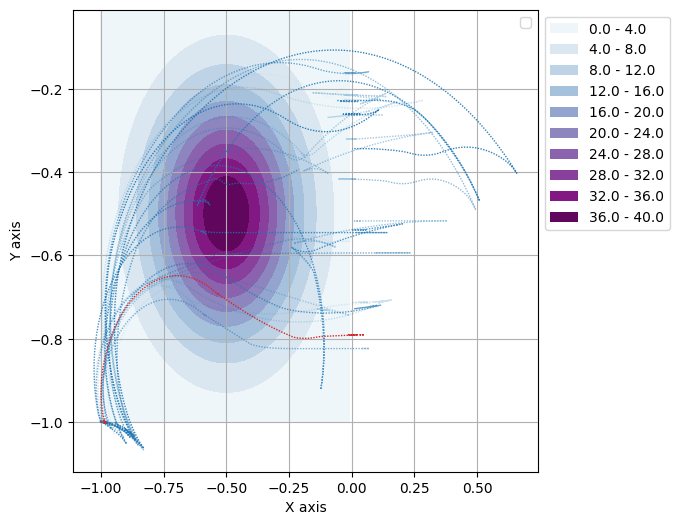

In [8]:
def plot_trajectories_given_trajectory(df, ref_df=None):
    seeds =  df["seed"].unique()

    fig, ax = plt.subplots(sharey=True, figsize=(6, 6))

    cs = ax.contourf(X, Y, Z, alpha=1, levels=10, cmap="BuPu")
    cs.cmap.set_over('red')
    cs.cmap.set_under('blue')
    cs.changed()

    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]


    for seed in seeds:
        sub_df_1 = df[df["seed"] == seed]
        trials = list(sub_df_1["file_name"].unique())
        trials.sort()

        for param_trial in trials:
            sub_df_2 = sub_df_1[sub_df_1["file_name"] == param_trial]
            alpha = (sub_df_2["iteration_id"].max()/sub_df_1["iteration_id"].max())

            ax.plot(sub_df_2["x [m]"], sub_df_2["y [m]"], 
                    linestyle=linestyle_dict[style[1]],
                    lw=1, 
                    color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 1 else colors[50], 
                    alpha=alpha)
        
    if ref_df is not None:
        ax.plot(ref_df["x [m]"], ref_df["y [m]"], 
                linestyle=linestyle_dict[style[5]],
                lw=2, 
                color=colors[10], 
                alpha=1,
                label="Nominal")

    traj_legend = ax.legend()
    ax.legend(proxy, 
                 [f"{cs.levels[l_i-1]} - {cs.levels[l_i]}" for l_i in range(1, len(cs.levels))],
                 bbox_to_anchor=(1, 1))
    
    ax.add_artist(traj_legend)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    
    # Show the plot
    ax.grid(True)

    fig.savefig("media/trajectories.svg", dpi=fig.dpi)

plot_trajectories_given_trajectory(concat_df)

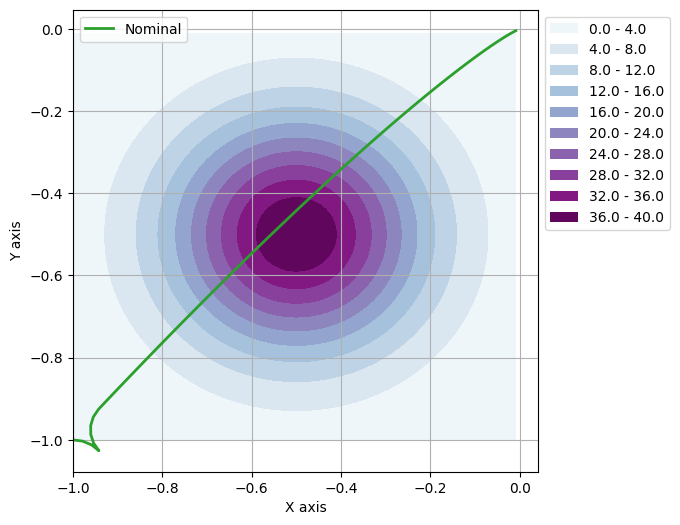

In [9]:
plot_trajectories_given_trajectory(clean_df, ref_df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


('0', 1)

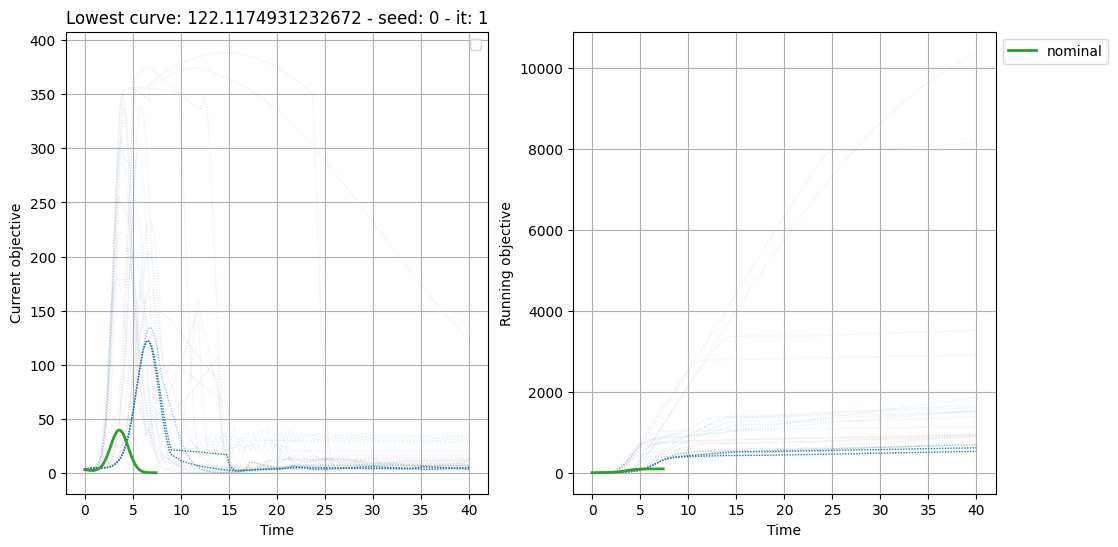

In [10]:
def plot_objective(df, ref_df=None):
    seeds = df["seed"].unique()
    lowest_current_value_runs = df.loc[:, ["seed", "iteration_id", "current_value"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value")
    lowest_current_value = lowest_current_value_runs.values[0, 0]
    lowest_current_value_info = lowest_current_value_runs.index[0]

    fig, ax = plt.subplots(1,2,sharey=False, figsize=(12, 6))

    for seed in seeds:
        sub_df_1 = df[df["seed"] == seed]
        trials = list(sub_df_1["file_name"].unique())
        trials.sort()

        for param_trial in trials:
            sub_df_2 = sub_df_1[sub_df_1["file_name"] == param_trial]
            # alpha = (sub_df_2["current_value"].max()/sub_df_1["current_value"].max())
            lowest_current_value
            rv = stats.norm(loc=lowest_current_value, scale=5)
            alpha = rv.pdf(sub_df_2["current_value"].max())*100
            alpha = np.clip(alpha, 0.1, 1)

            ax[0].plot(sub_df_2["time"], sub_df_2["current_value"], 
                    linestyle=linestyle_dict[style[1]],
                    lw=1, 
                    color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 5 else colors[50], 
                    alpha=alpha)
            
            ax[1].plot(sub_df_2["time"], sub_df_2["running_objective"], 
                    linestyle=linestyle_dict[style[1]],
                    lw=1, 
                    color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 5 else colors[50], 
                    alpha=alpha)
        
    if ref_df is not None:
        ax[0].plot(ref_df["time"], ref_df["current_value"], 
                linestyle=linestyle_dict[style[5]],
                lw=2, 
                color=colors[10], 
                alpha=1)
        
        ax[1].plot(ref_df["time"], ref_df["running_objective"], 
                linestyle=linestyle_dict[style[5]],
                lw=2, 
                color=colors[10], 
                alpha=1,
                label="nominal")

    ax[0].set_title("Lowest curve: {} - seed: {} - it: {}".format(lowest_current_value, lowest_current_value_info[0], lowest_current_value_info[1]))
    # draw goal pose
    ax[0].legend(bbox_to_anchor=(1, 1))
    ax[1].legend(bbox_to_anchor=(1, 1))

    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Current objective')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Running objective')
    
    # Show the plot
    ax[0].grid(True)
    ax[1].grid(True)

    fig.savefig("media/objectives.svg", dpi=fig.dpi)


plot_objective(concat_df, ref_df)

# concat_df.loc["iteration_id"]
# clean_df.loc[:, ["seed", "iteration_id", "current_value"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value").values[0, 0]
concat_df.loc[:, ["seed", "iteration_id", "current_value"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value").index[0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


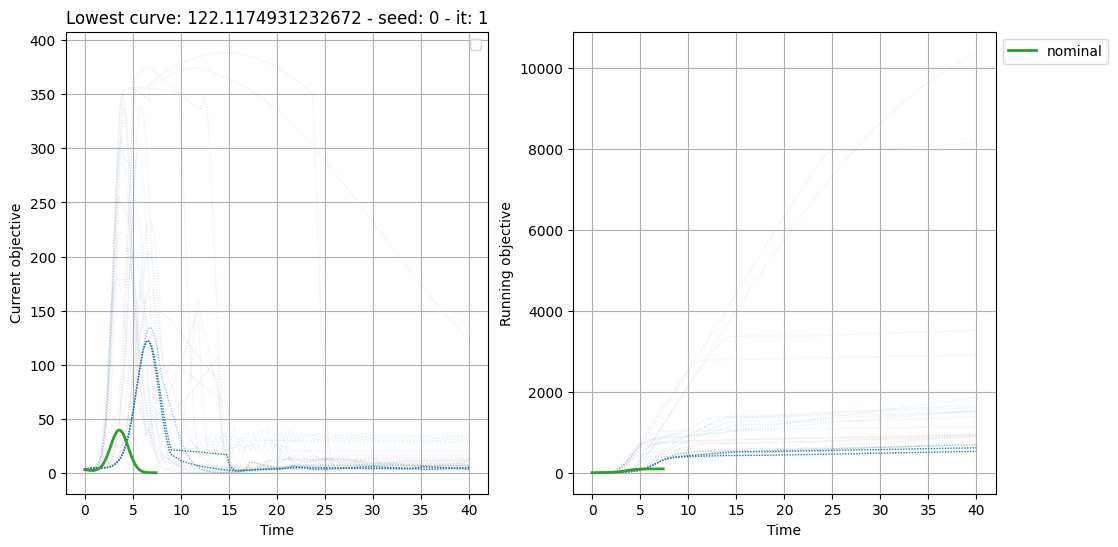

In [11]:
plot_objective(concat_df, ref_df)

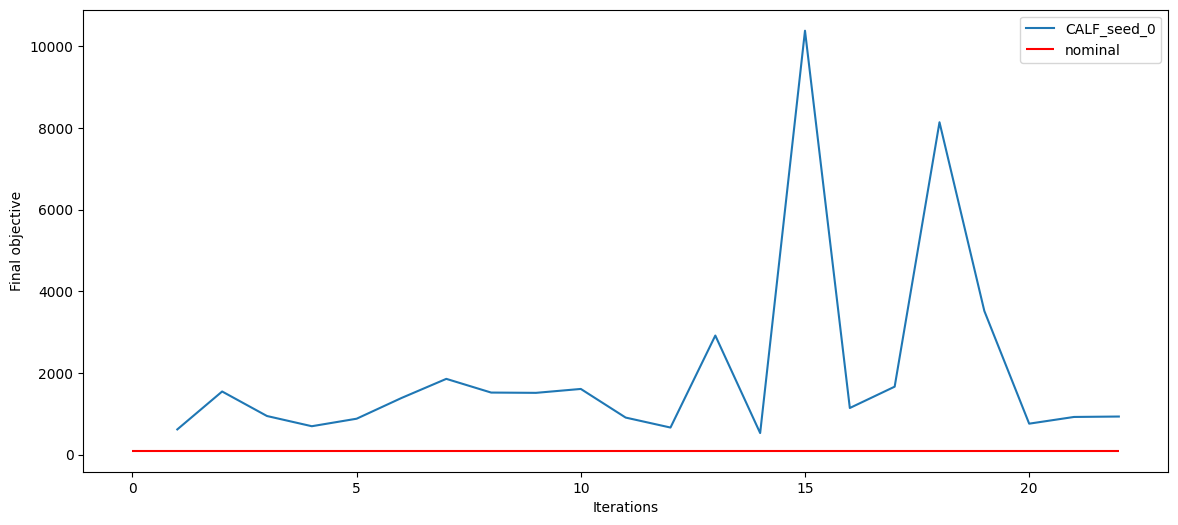

In [12]:
def plot_final_cost(df):
    fig, ax = plt.subplots(figsize=(14, 6))

    seeds = df["seed"].unique()
    for seed in seeds:
        sub_df_1 = df[df["seed"] == seed]
        sub_df_1.groupby("iteration_id")["running_objective"].max().plot(ax=ax, label=f"CALF_seed_{seed}")

    ax.hlines(ref_df["running_objective"].max(), 
            xmin=0, 
            xmax=df["iteration_id"].max(), 
            colors="red",
            label="nominal")

    ax.legend()
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Final objective')

plot_final_cost(concat_df)

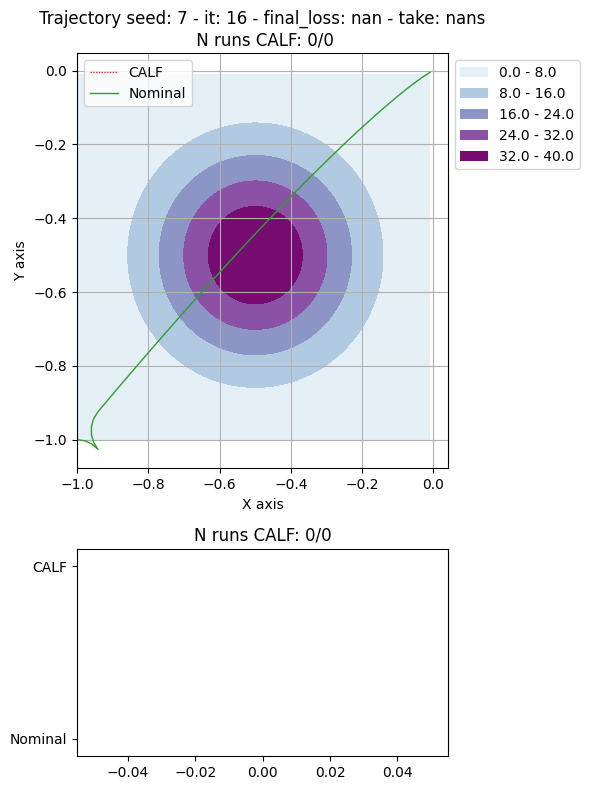

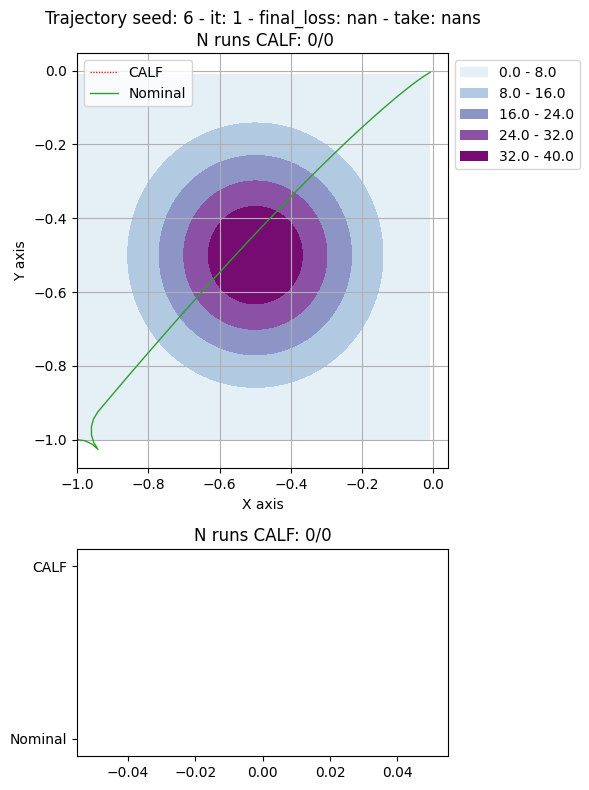

In [13]:
def plot_chosen_trajectory(df, it, seed=0, ref_df=None):
    fig, ax = plt.subplots(2, 1, sharey=False, figsize=(6, 8), height_ratios=[2, 1])

    cs = ax[0].contourf(X, Y, Z, alpha=1, levels=5, cmap="BuPu")
    cs.cmap.set_over('red')
    cs.cmap.set_under('blue')
    cs.changed()

    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]

    sub_df_1 = df[df["seed"] == str(seed)]
    sub_df_2 = sub_df_1[sub_df_1["iteration_id"] == it]
    ax[0].plot(sub_df_2["x [m]"], sub_df_2["y [m]"], 
            linestyle=linestyle_dict[style[1]],
            lw=1, 
            color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 5 else colors[50], 
            alpha=1,
            label="CALF")

    ax[0].set_title("Trajectory seed: {} - it: {} - final_loss: {:.2f} - take: {:.2f}s\n N runs CALF: {}/{}".format(
                    seed, 
                    it, 
                    sub_df_2["running_objective"].max(), 
                    sub_df_2["time"].max(),
                    sub_df_2["use_calf"].sum(),
                    sub_df_2["use_calf"].count()))
    
    ax[1].plot(sub_df_2["time"], sub_df_2["use_calf"])
    ax[1].set_ylim([-0.1, 1.1])
    ax[1].set_yticks([0, 1], ["Nominal", "CALF"])
    ax[1].set_title("N runs CALF: {}/{}".format(
        sub_df_2["use_calf"].sum(),
        sub_df_2["use_calf"].count()
    ))

    if ref_df is not None:
        ax[0].plot(ref_df["x [m]"], ref_df["y [m]"], 
                linestyle=linestyle_dict[style[5]],
                lw=1, 
                color=colors[10], 
                alpha=1,
                label="Nominal")

    traj_legend = ax[0].legend()
    ax[0].legend(proxy, 
                 [f"{cs.levels[l_i-1]} - {cs.levels[l_i]}" for l_i in range(1, len(cs.levels))],
                 bbox_to_anchor=(1, 1))

    ax[0].set_xlabel('X axis')
    ax[0].set_ylabel('Y axis')
    
    ax[0].add_artist(traj_legend)
    # Show the plot
    ax[0].grid(True)
    plt.tight_layout()
    fig.savefig("media/trajectories_with_ref.svg", dpi=fig.dpi)

plot_chosen_trajectory(clean_df, ref_df=ref_df, it=16, seed=7)
plot_chosen_trajectory(clean_df, ref_df=ref_df, it=1, seed=6)

/tmp/ipykernel_17216/4272359700.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 1, sharey=False, figsize=(6, 8), height_ratios=[1, 1])


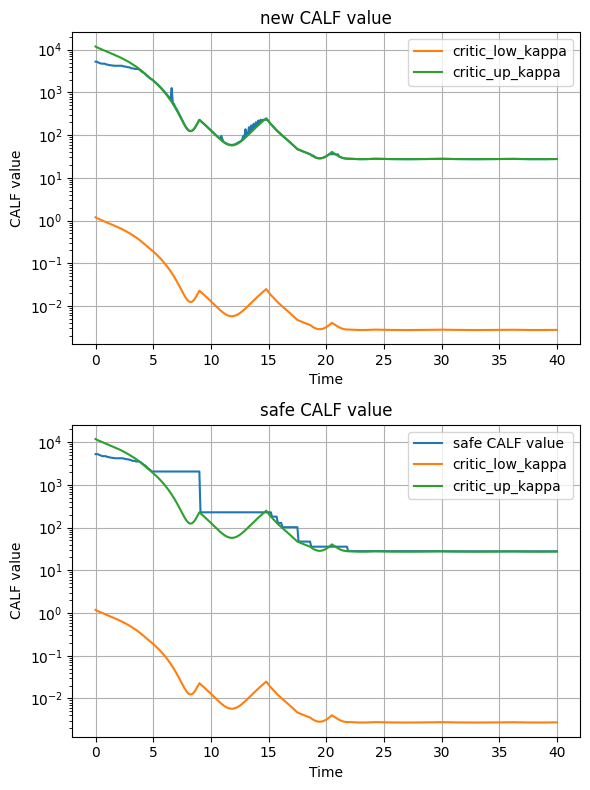

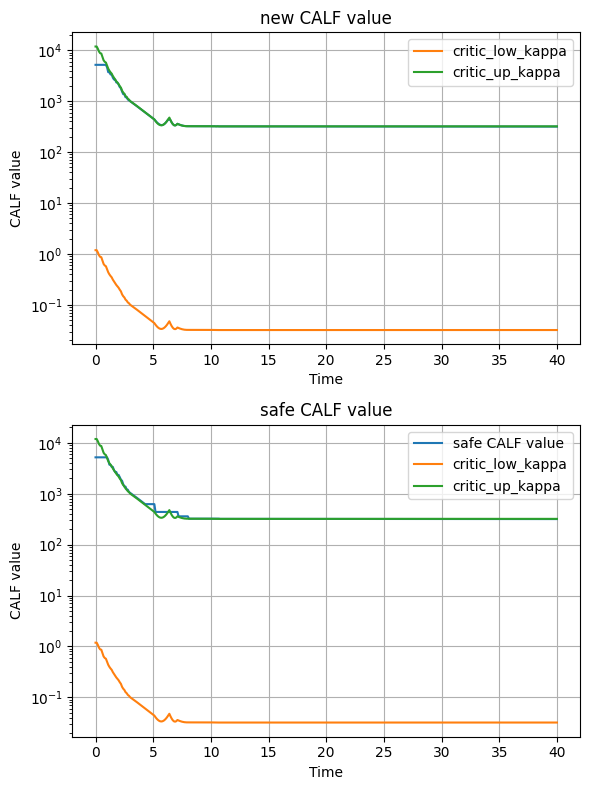

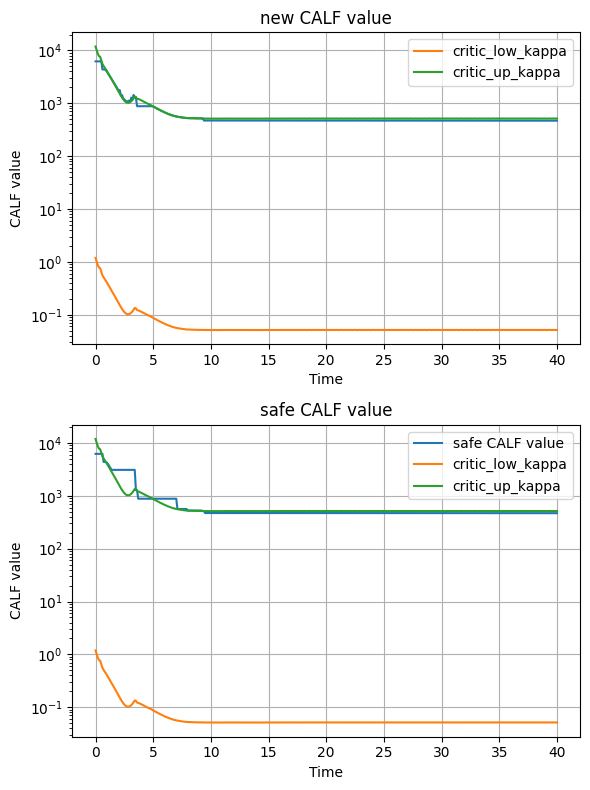

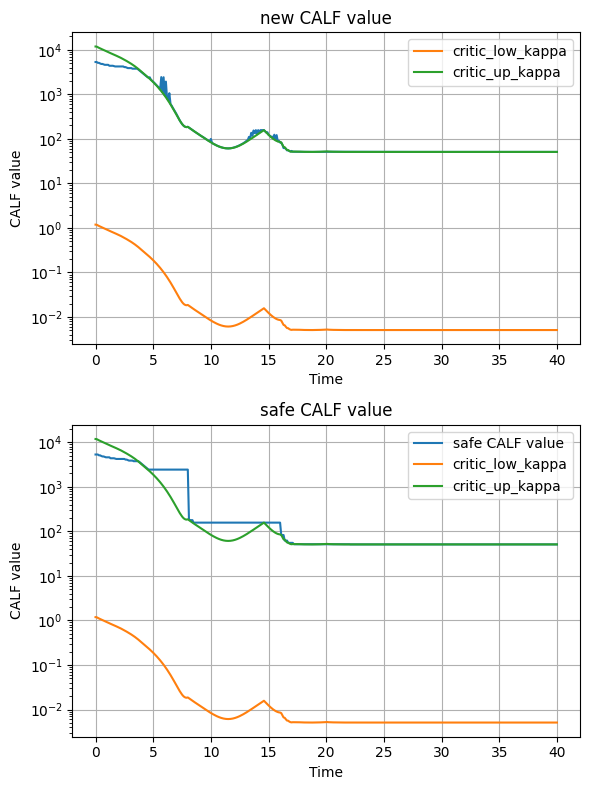

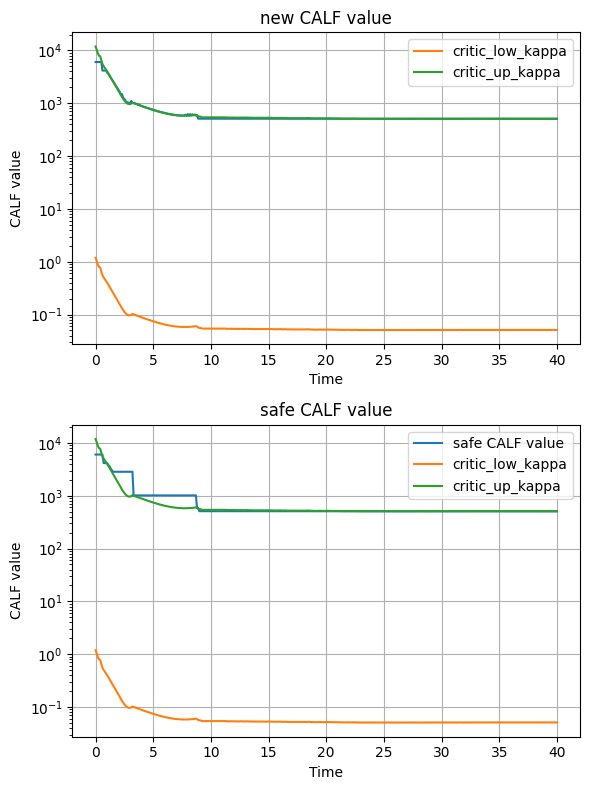

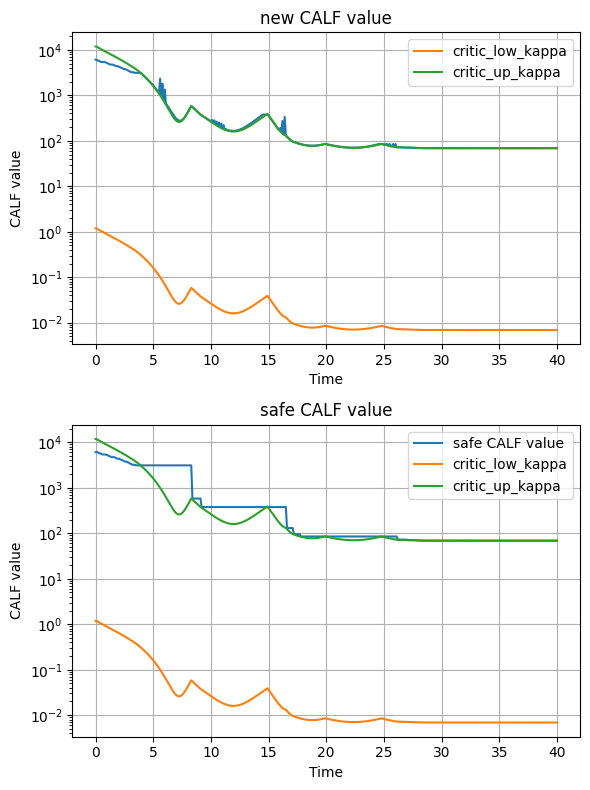

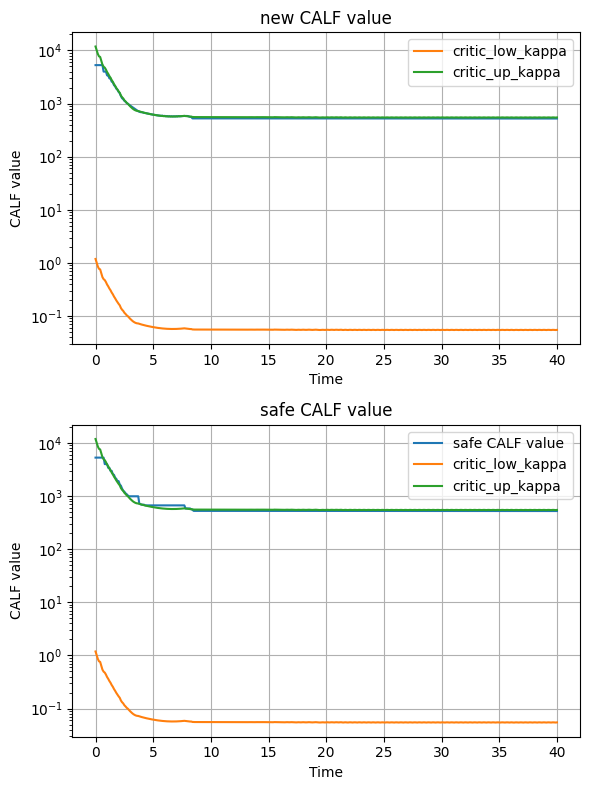

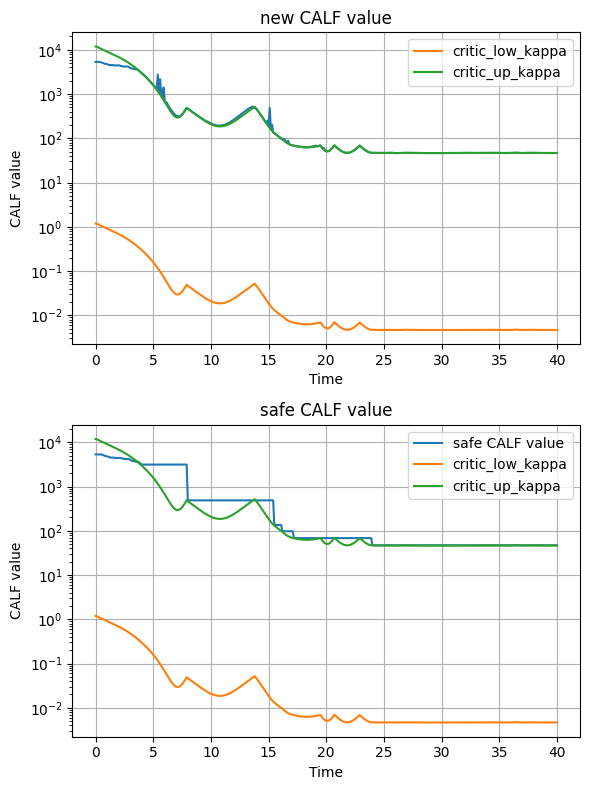

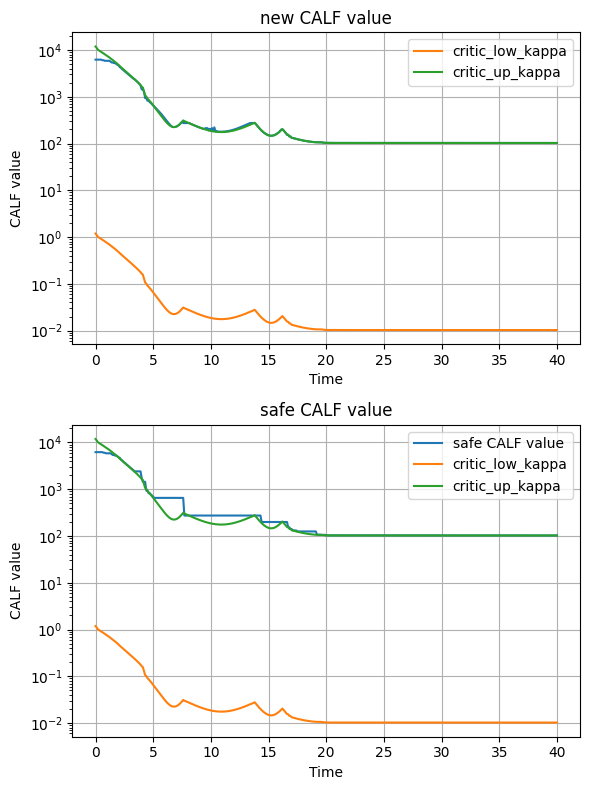

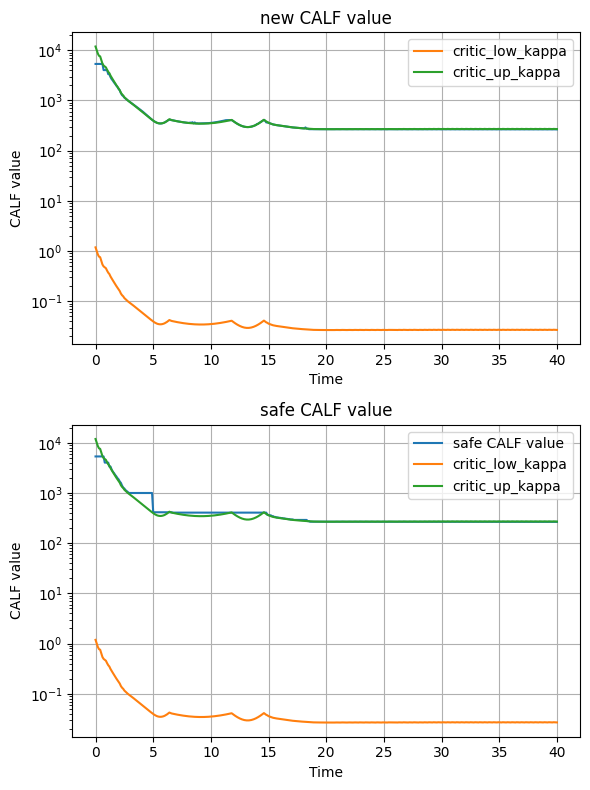

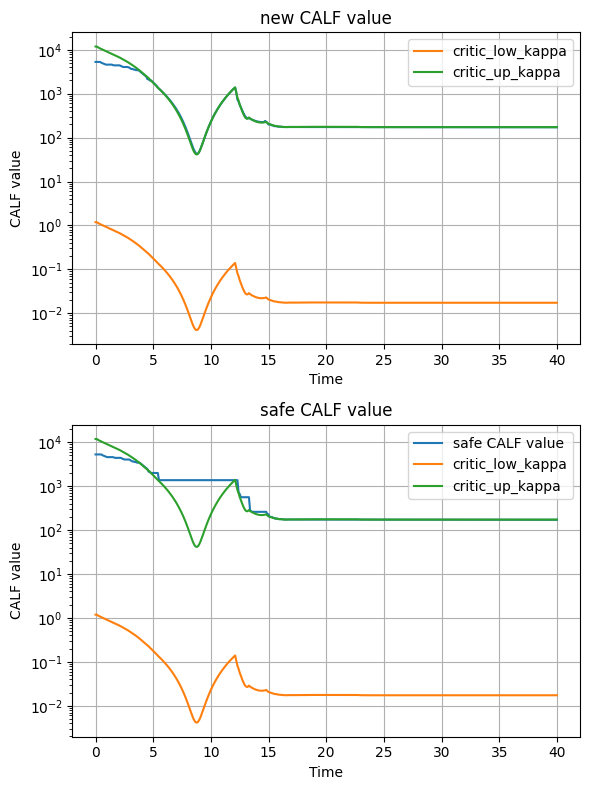

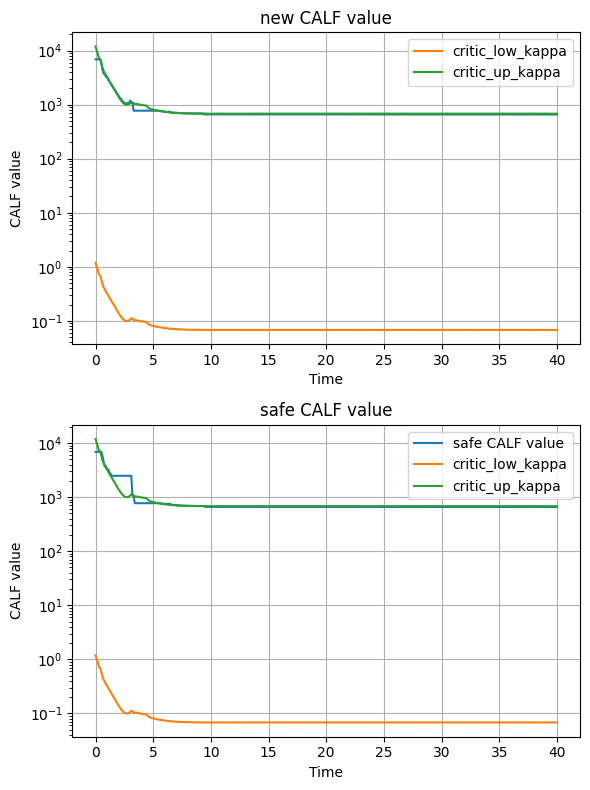

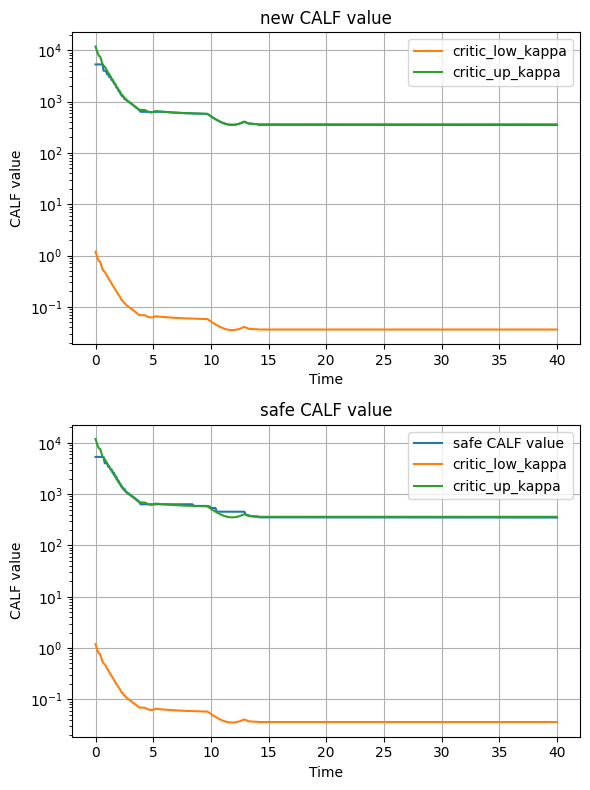

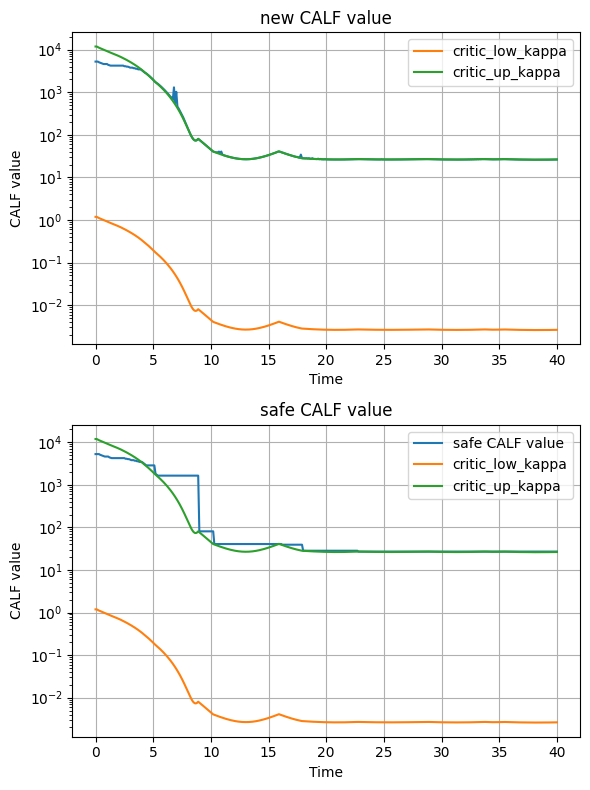

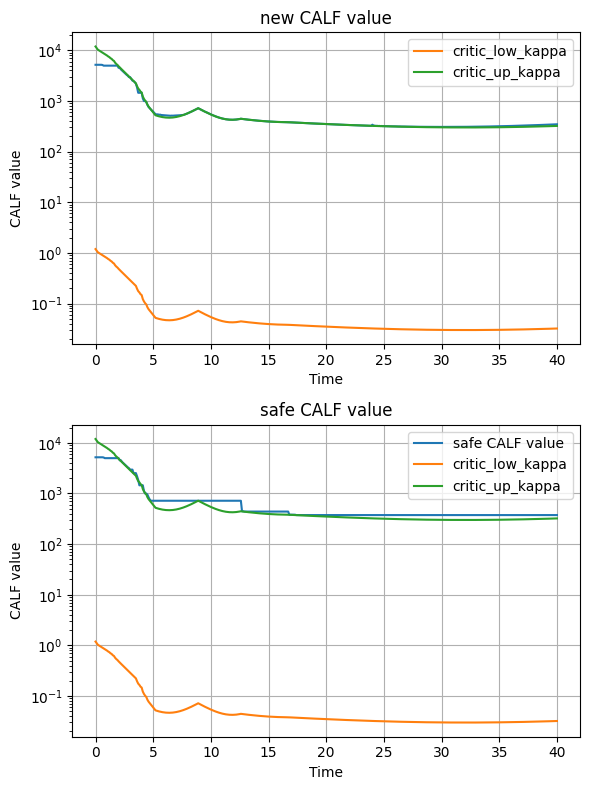

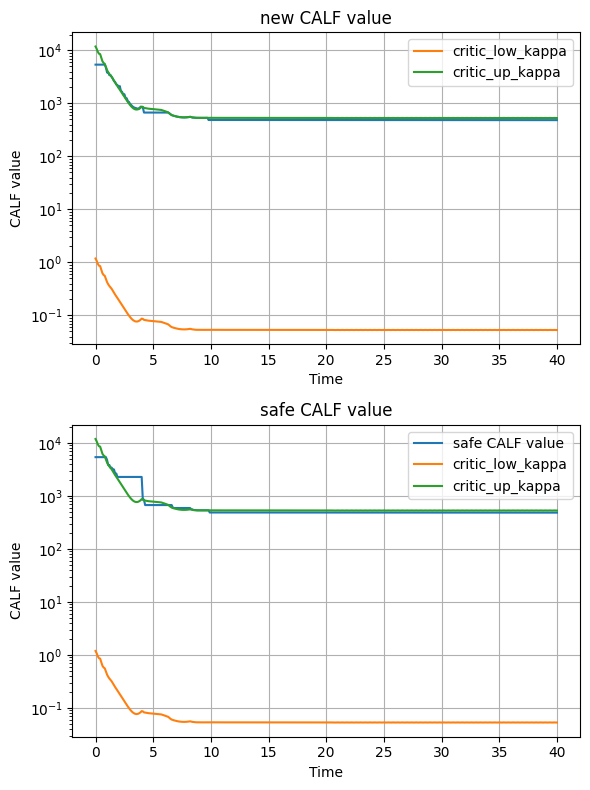

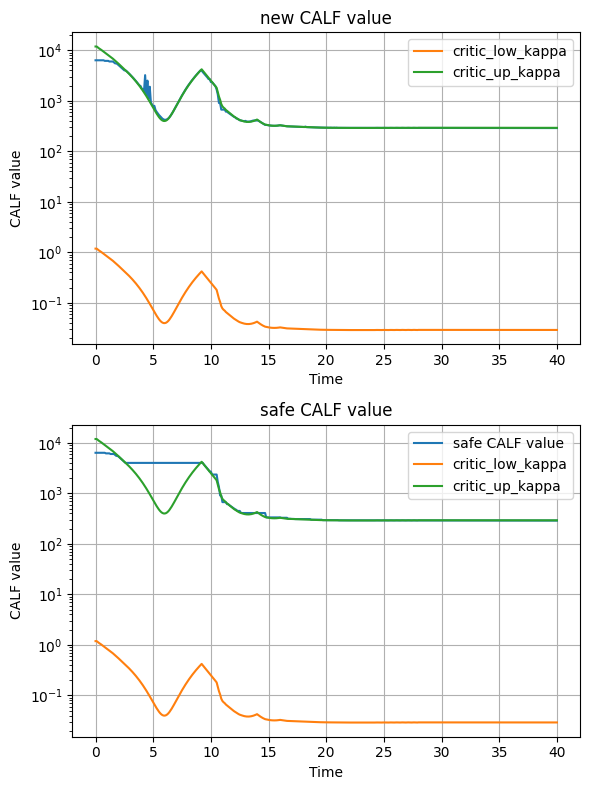

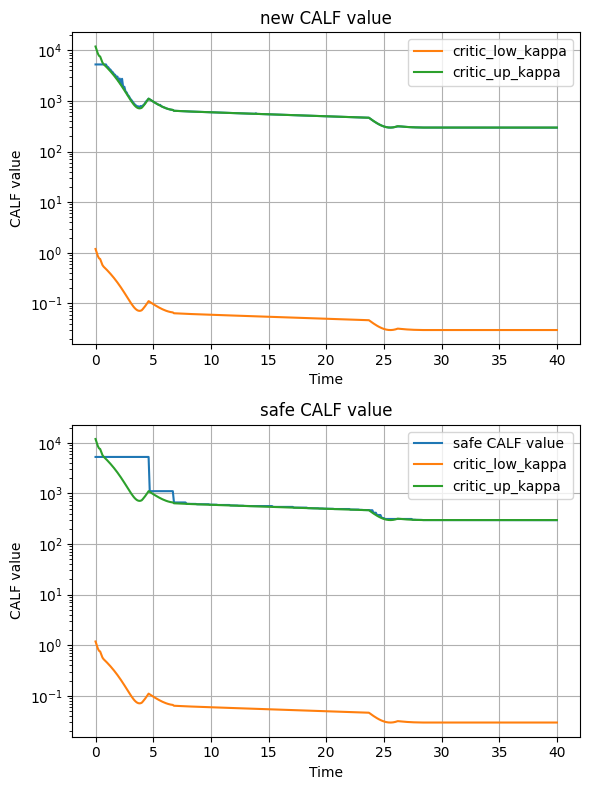

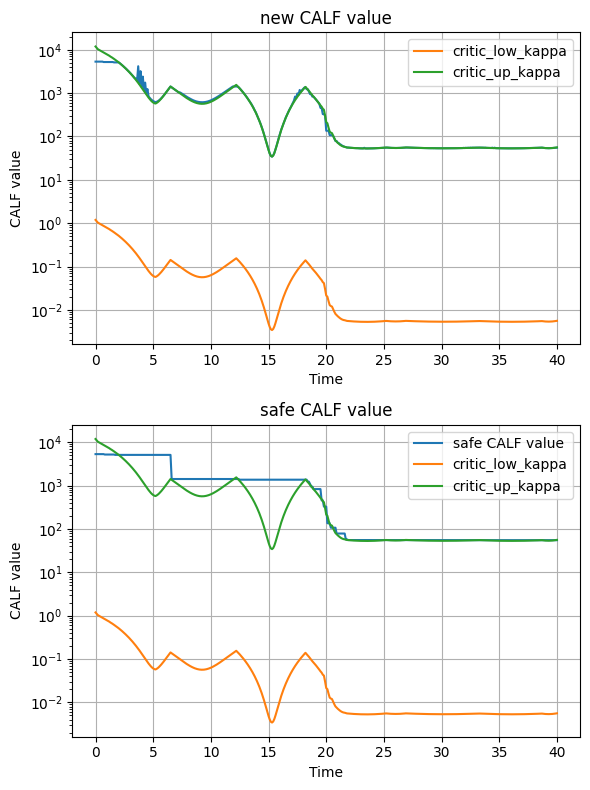

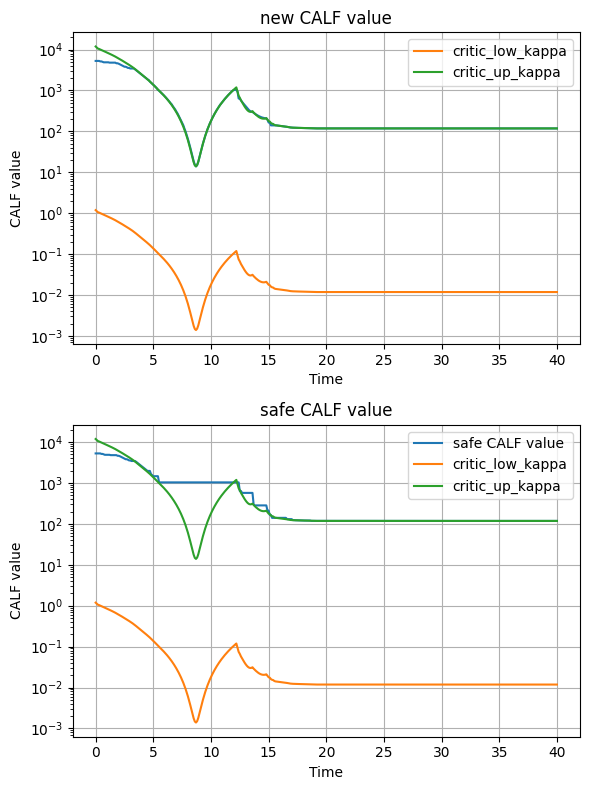

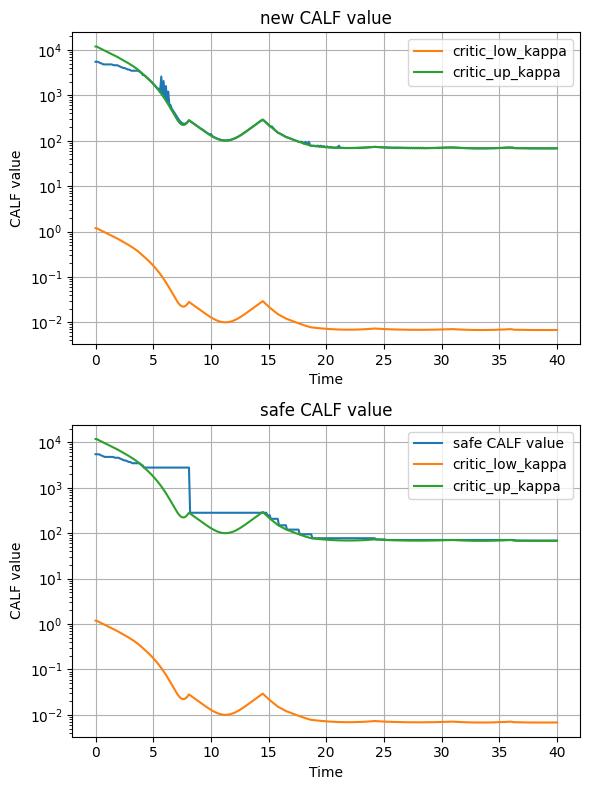

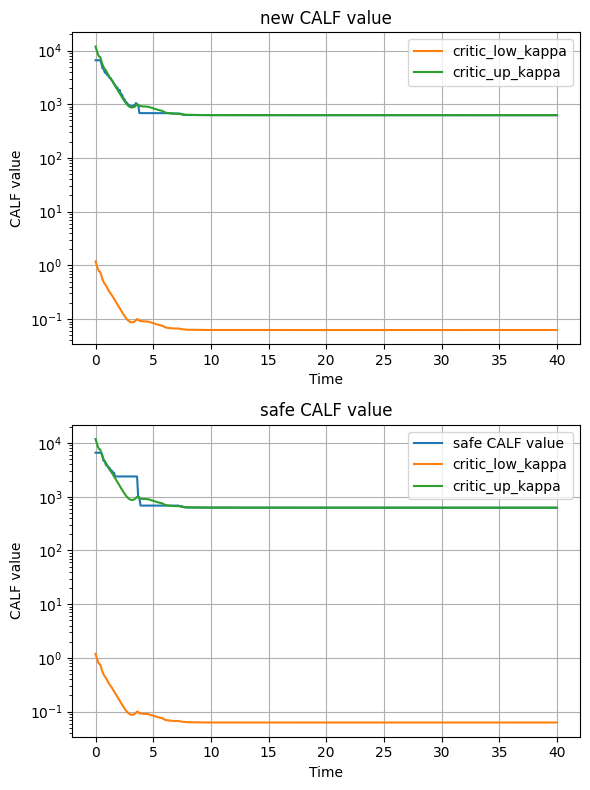

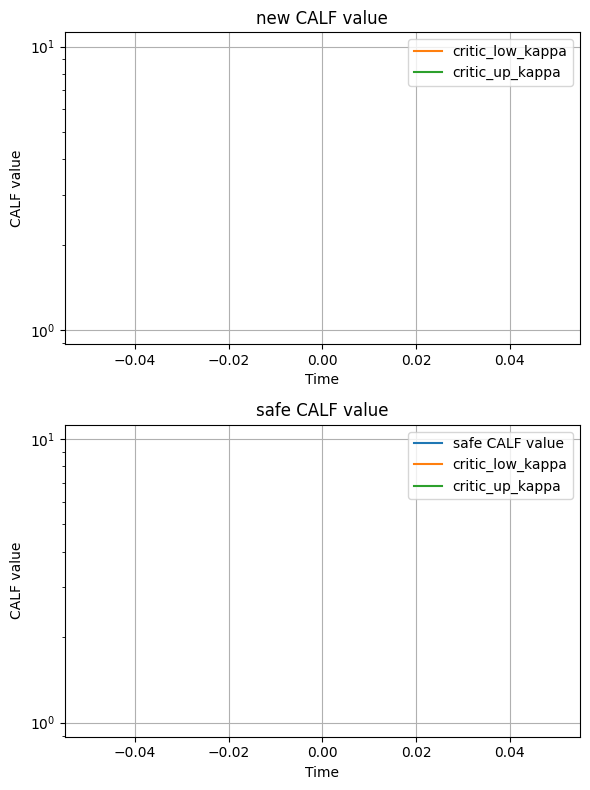

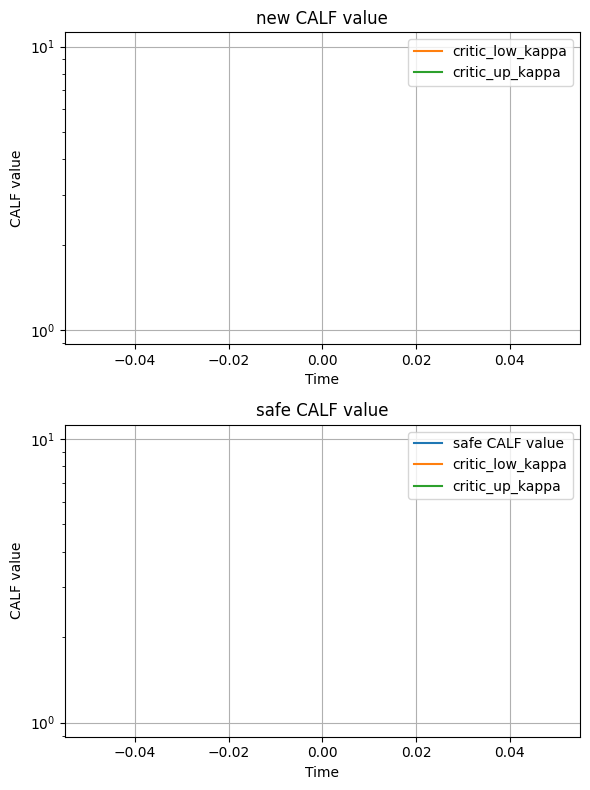

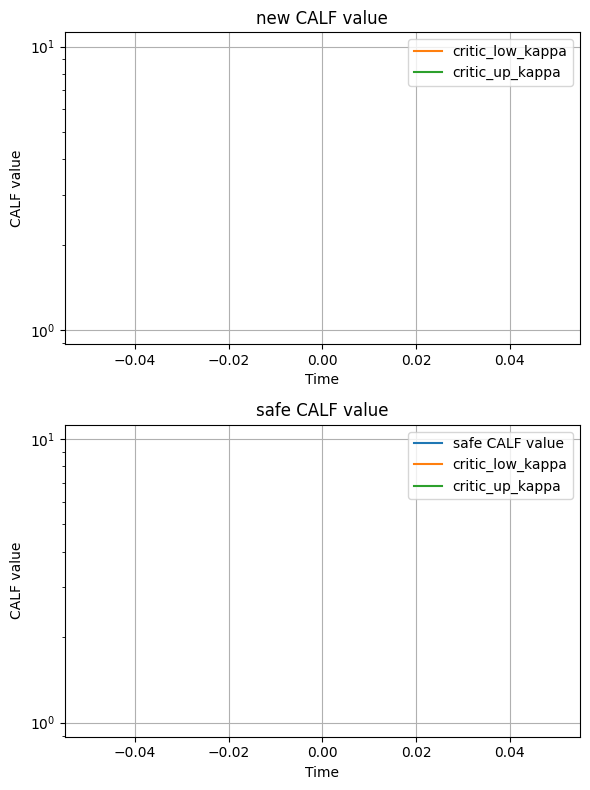

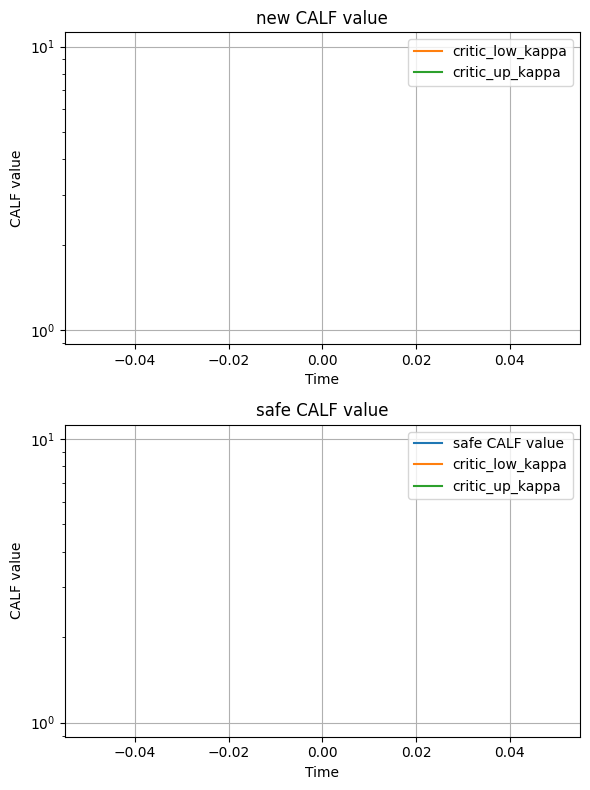

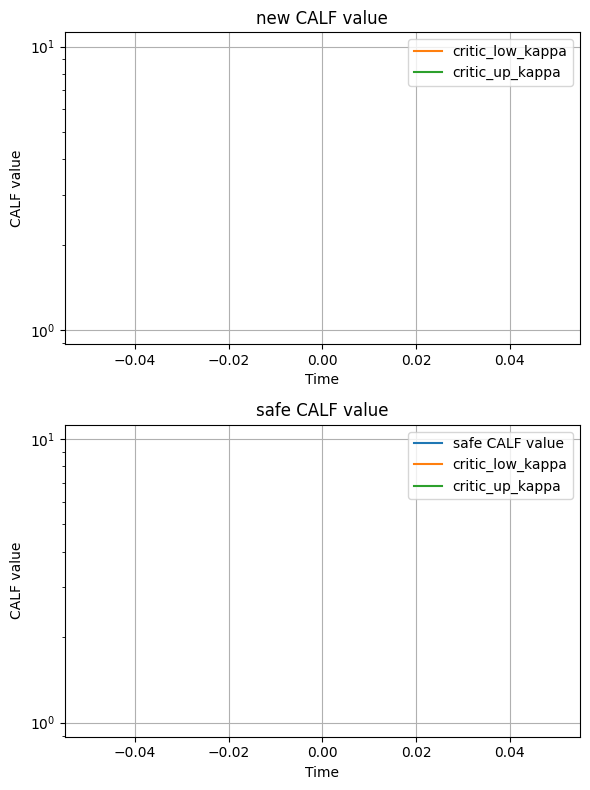

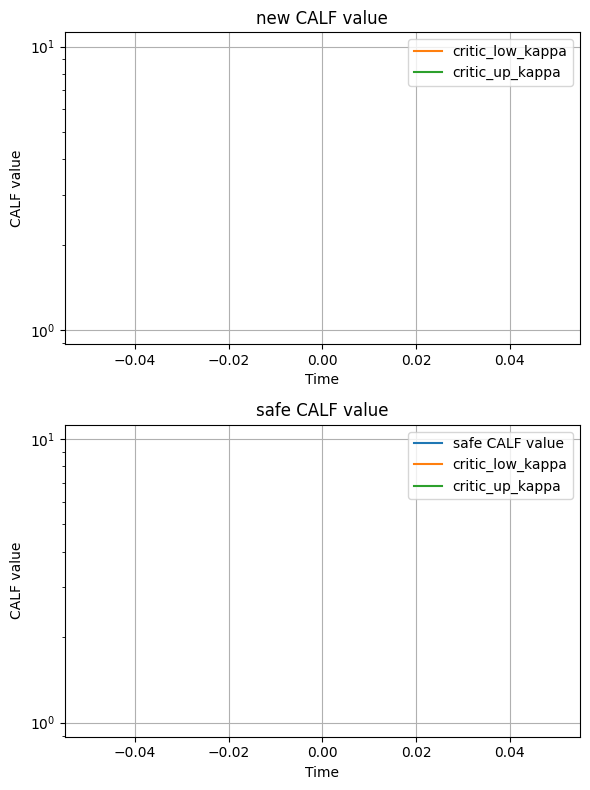

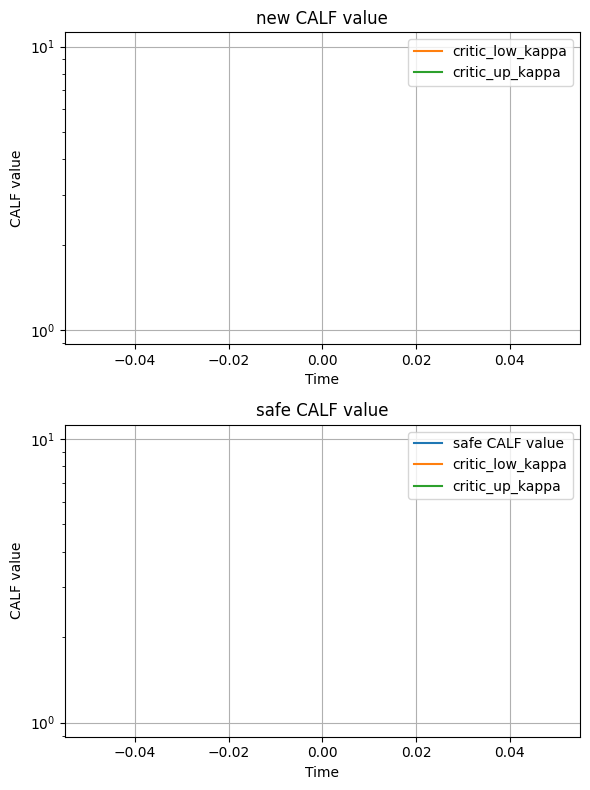

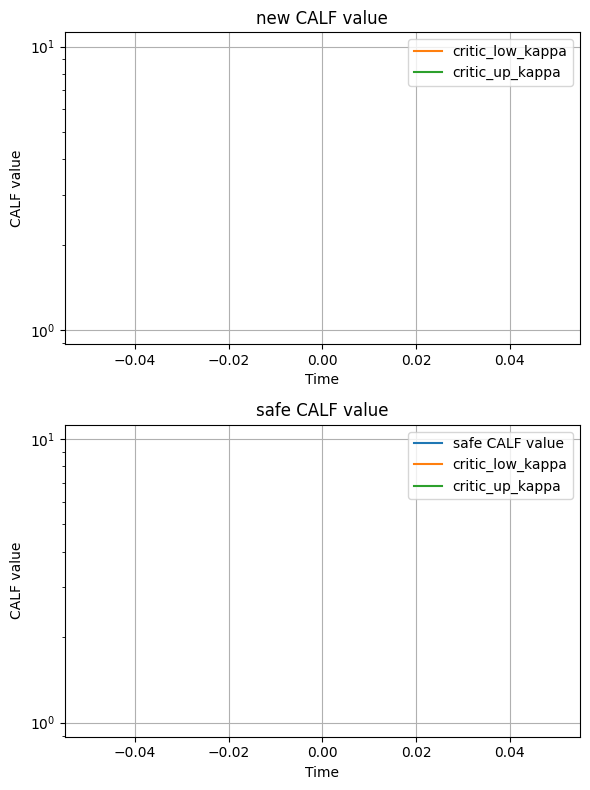

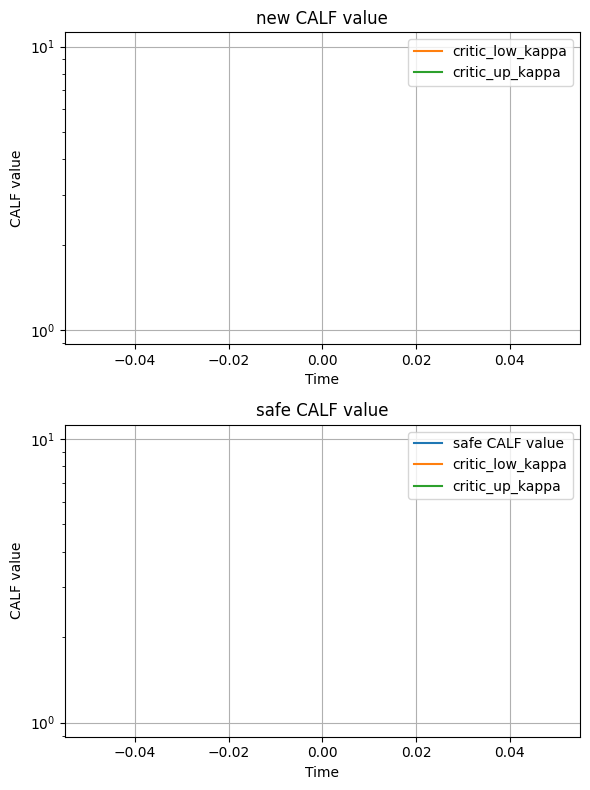

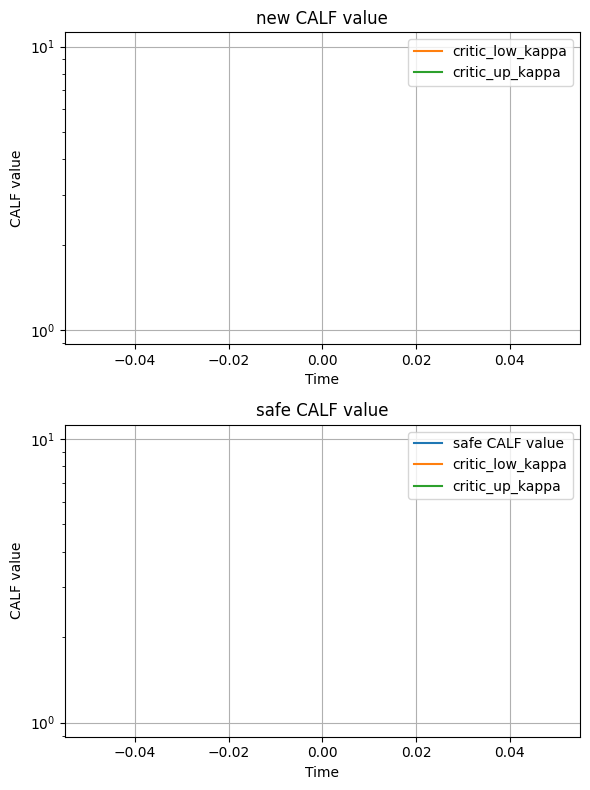

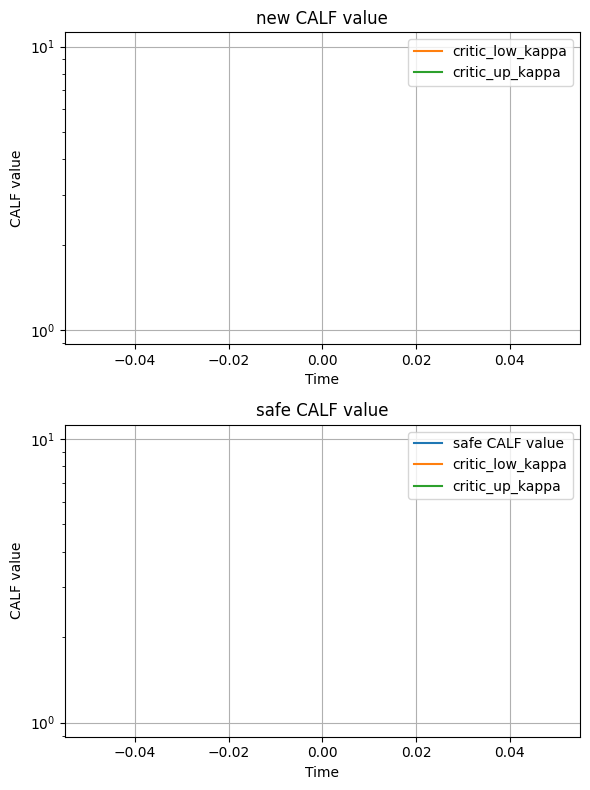

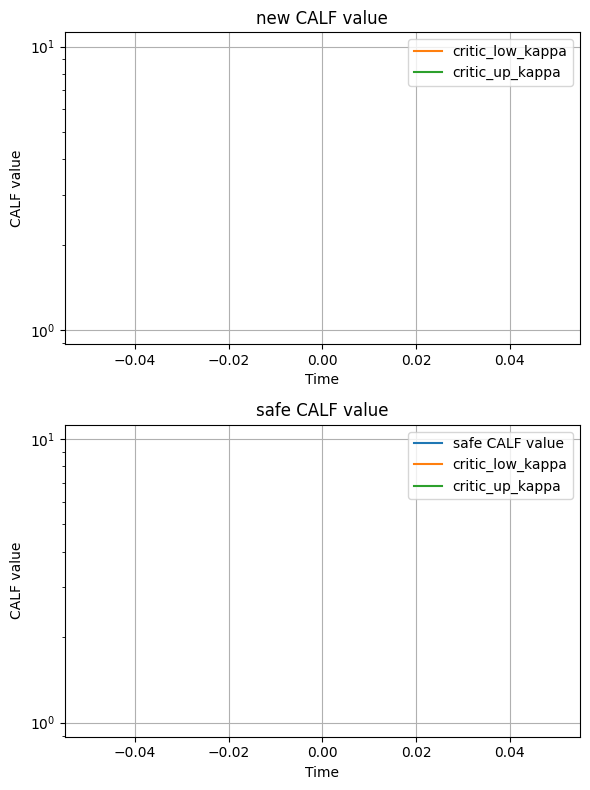

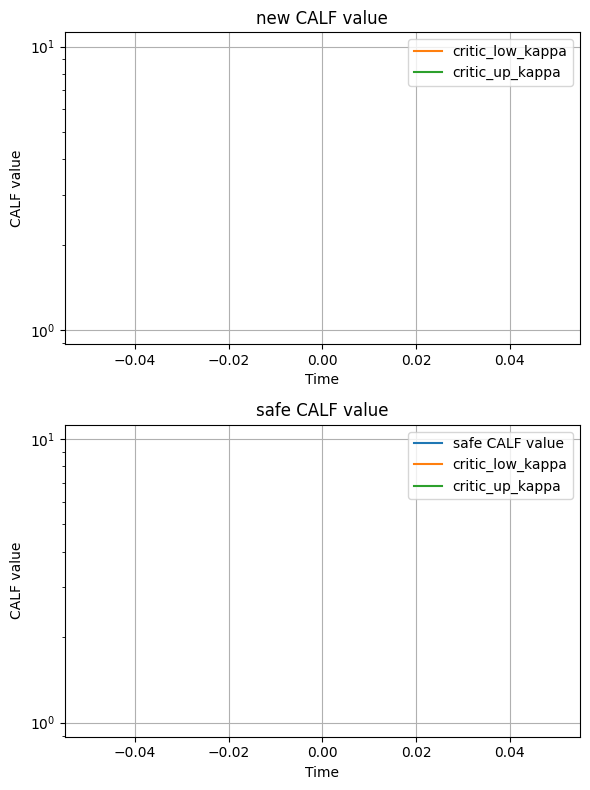

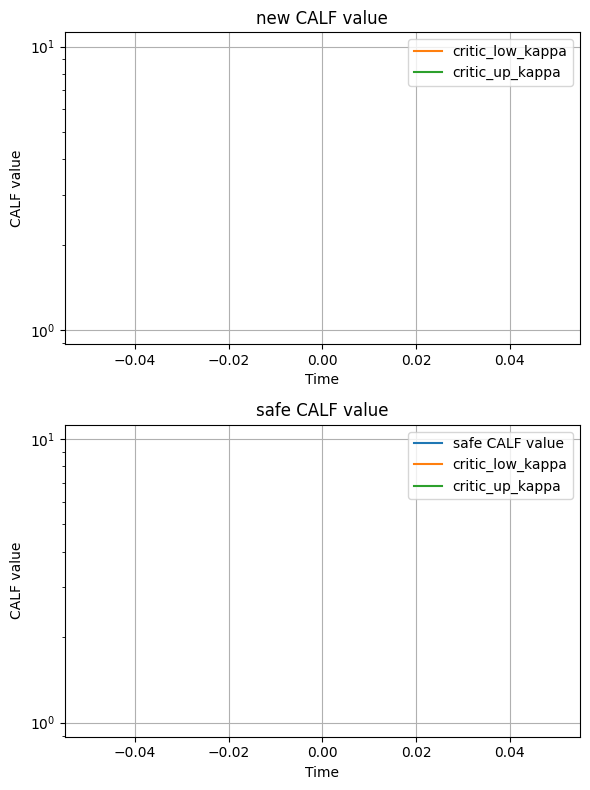

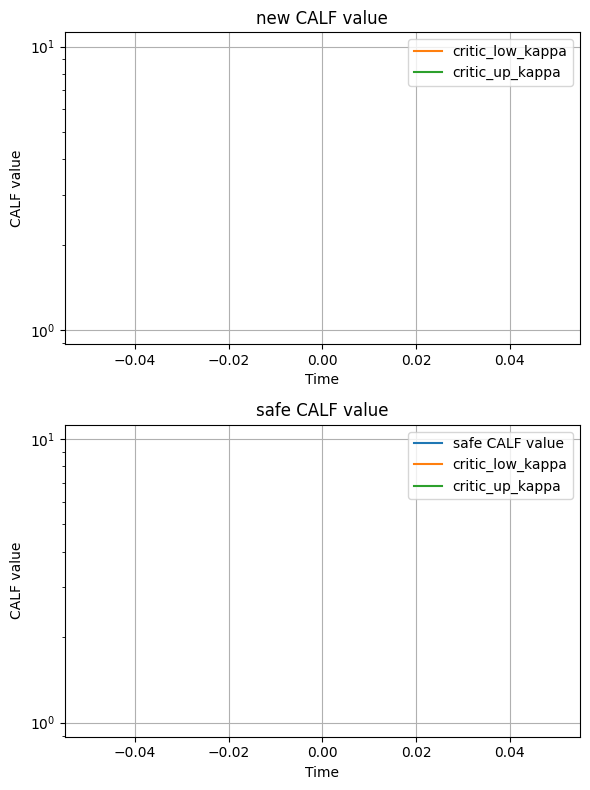

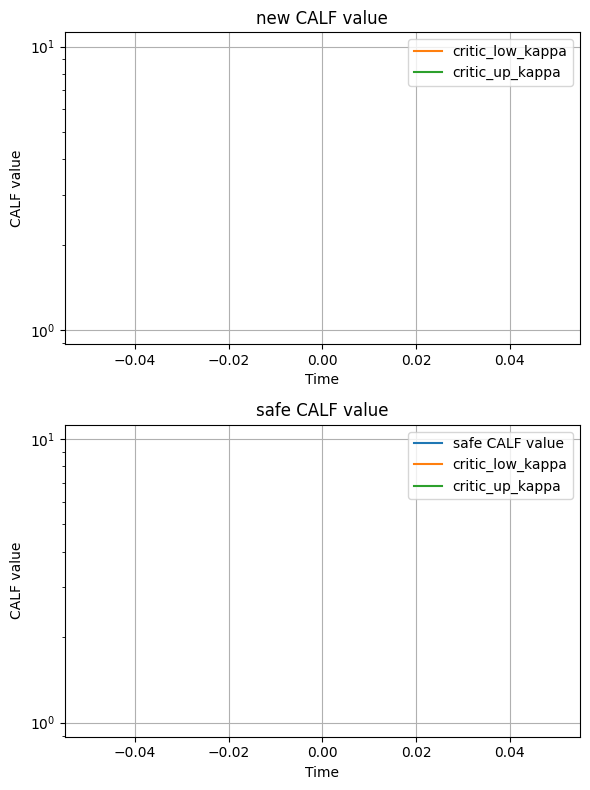

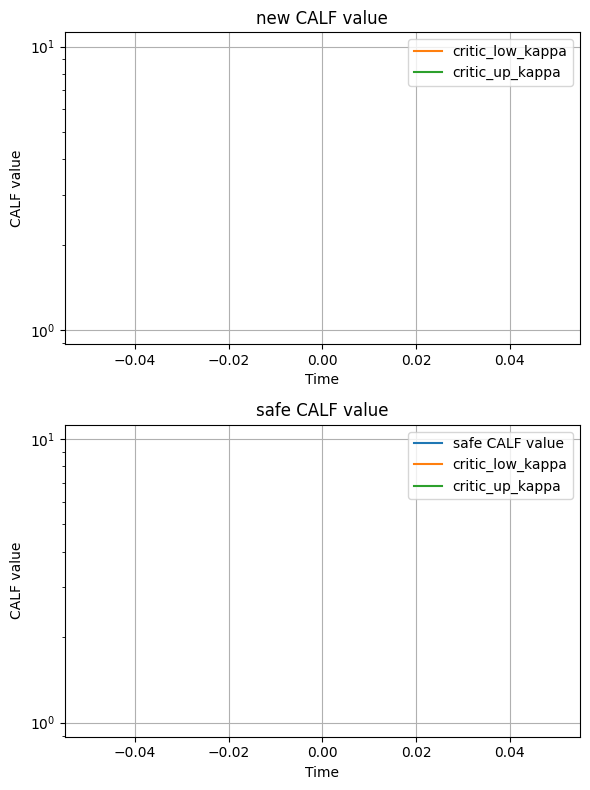

In [14]:
def plot_chosen_calf_value(df, it, seed=0):
    fig, ax = plt.subplots(2, 1, sharey=False, figsize=(6, 8), height_ratios=[1, 1])

    sub_df_1 = df[df["seed"] == str(seed)]
    sub_df_2 = sub_df_1[sub_df_1["iteration_id"] == it]
    ax[0].plot(sub_df_2["time"], sub_df_2["critic_new"])
    ax[0].plot(sub_df_2["time"], sub_df_2["critic_low_kappa"], label="critic_low_kappa")
    ax[0].plot(sub_df_2["time"], sub_df_2["critic_up_kappa"], label="critic_up_kappa")
    ax[0].set_title("new CALF value")
    
    ax[1].plot(sub_df_2["time"], sub_df_2["critic_safe"], label="safe CALF value")
    ax[1].plot(sub_df_2["time"], sub_df_2["critic_low_kappa"], label="critic_low_kappa")
    ax[1].plot(sub_df_2["time"], sub_df_2["critic_up_kappa"], label="critic_up_kappa")
    ax[1].set_title("safe CALF value")

    ax[0].legend()
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('CALF value')
    ax[0].grid(True)
    ax[0].set_yscale('log')

    ax[1].legend()
    ax[1].set_yscale('log')
    ax[1].grid(True)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('CALF value')
    plt.tight_layout()
    # fig.savefig("media/CALF_value.svg", dpi=fig.dpi)

for i in range(1, 40):
    plot_chosen_calf_value(concat_df, it=i, seed=0)

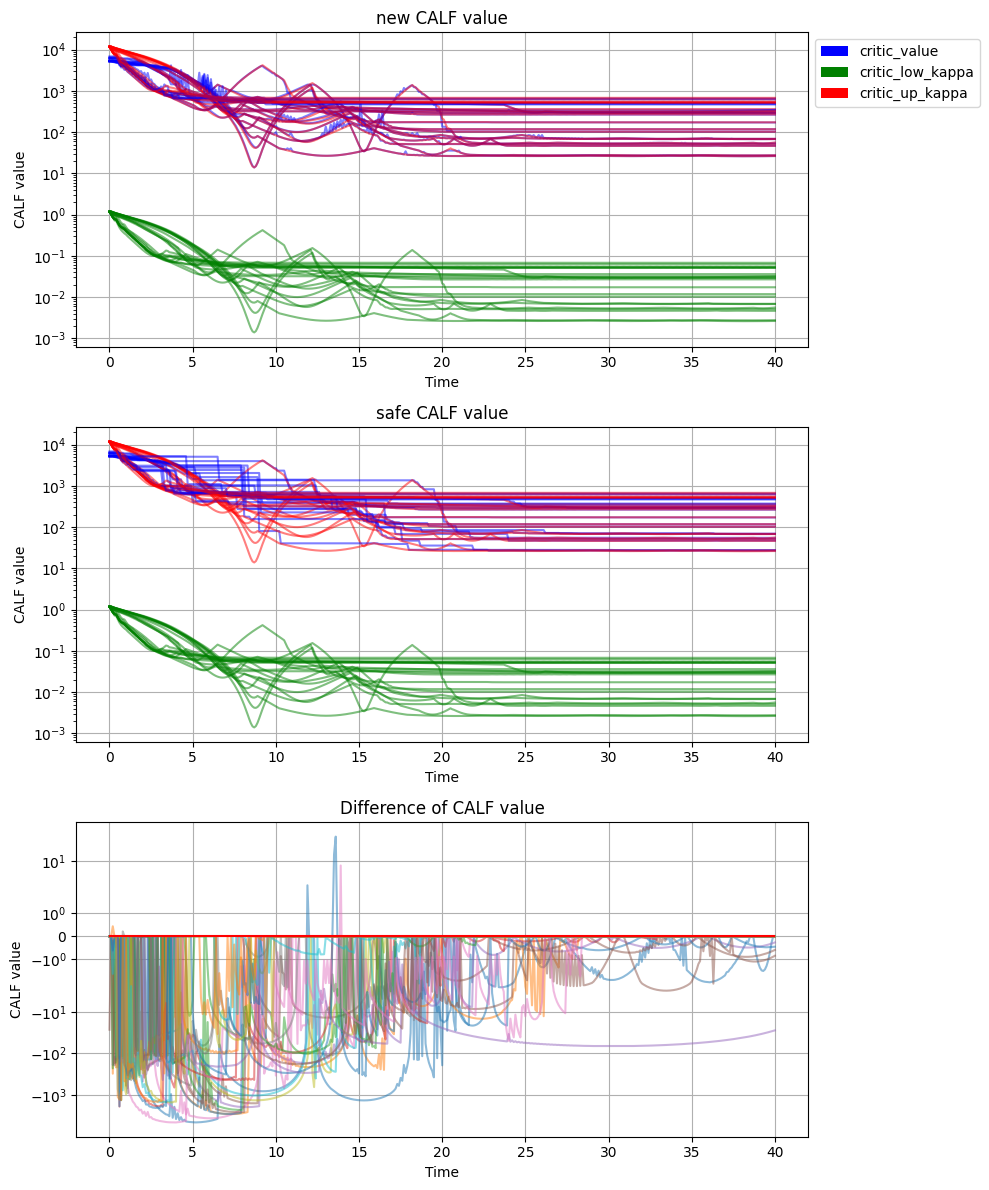

In [15]:
def plot_all_calf_value(df):
    fig, ax = plt.subplots(3, 1, sharey=False, figsize=(10, 12), height_ratios=[1, 1, 1])

    seeds = df.seed.unique()
    colors = {
        "critic_value": "blue",
        "critic_low_kappa": "green",
        "critic_up_kappa": "red",
    }

    for seed in seeds:
        sub_df_1 = df[df["seed"] == str(seed)]

        for it in sub_df_1["iteration_id"].unique():
            sub_df_2 = sub_df_1[sub_df_1["iteration_id"] == it]
            ax[0].plot(sub_df_2["time"], sub_df_2["critic_new"], color=colors["critic_value"], alpha=0.5)
            ax[0].plot(sub_df_2["time"], sub_df_2["critic_low_kappa"], color=colors["critic_low_kappa"], alpha=0.5)
            ax[0].plot(sub_df_2["time"], sub_df_2["critic_up_kappa"], color=colors["critic_up_kappa"], alpha=0.5)
            
            ax[1].plot(sub_df_2["time"], sub_df_2["critic_safe"], color=colors["critic_value"], alpha=0.5)
            ax[1].plot(sub_df_2["time"], sub_df_2["critic_low_kappa"], color=colors["critic_low_kappa"], alpha=0.5)
            ax[1].plot(sub_df_2["time"], sub_df_2["critic_up_kappa"], color=colors["critic_up_kappa"], alpha=0.5)

            ax[2].plot(sub_df_2["time"], sub_df_2["calf_diff"], alpha=0.5)
    
    proxy = [plt.Rectangle((0,0),1,1,fc = c) for c in colors.values()]
    ax[0].legend(proxy, 
                 [f"{l}" for l in colors.keys()],
                 bbox_to_anchor=(1, 1))
    
    ax[0].grid(True)
    ax[0].set_title("new CALF value")
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('CALF value')
    ax[0].set_yscale('log')

    ax[1].grid(True)
    ax[1].set_title("safe CALF value")
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('CALF value')
    ax[1].set_yscale('log')


    ax[2].hlines(- 1e-5 * 0.1, 
        xmin=0, 
        xmax=df["time"].max(), 
        colors="red",
        label="desired decay rate")
    ax[2].grid(True)
    ax[2].set_title("Difference of CALF value")
    ax[2].set_xlabel('Time')
    ax[2].set_ylabel('CALF value')
    ax[2].set_yscale('symlog')
    
    plt.tight_layout()
    fig.savefig("media/CALF_value_vs_2_kappa.svg", dpi=fig.dpi)

plot_all_calf_value(concat_df)

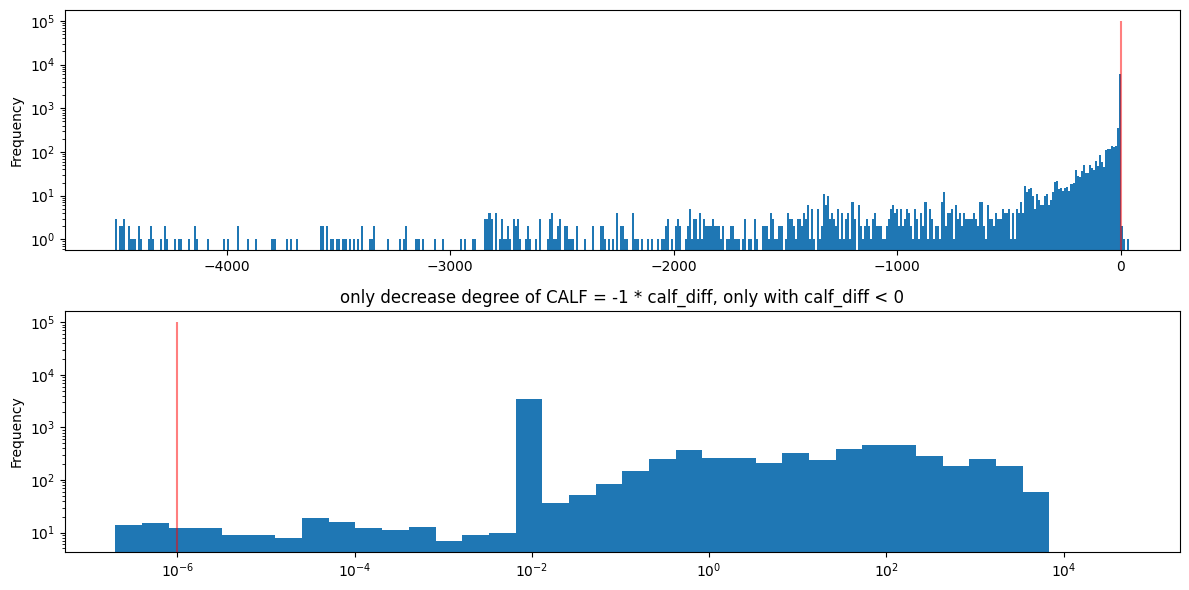

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
concat_df.calf_diff.plot(kind="hist", log=True, bins=500, ax=ax[0])
ax[0].vlines(x=- 1e-5 * 0.1, ymin=0, ymax=1e5, color="red", alpha=0.5)

only_negative_calf_diff = concat_df.calf_diff[concat_df.calf_diff < 0]
only_negative_calf_diff = -1 * only_negative_calf_diff

range_calf_diff = [1e-7 * 2 ** i for i in range(1, 40)]
range_calf_diff.sort()
if np.max(range_calf_diff) < only_negative_calf_diff.max():
    range_calf_diff += [only_negative_calf_diff.max()] 

only_negative_calf_diff.plot(kind="hist", log=True, bins=range_calf_diff, ax=ax[1])
# only_negative_calf_diff.plot(kind="hist", log=True, bins=500, ax=ax[1])

ax[1].vlines(x=1e-5 * 0.1, ymin=0, ymax=1e5, color="red", alpha=0.5)
ax[1].set_xscale('log')
ax[1].set_title("only decrease degree of CALF = -1 * calf_diff, only with calf_diff < 0")

plt.tight_layout()
# range_calf_diff

count    8822.000000
mean     -150.135832
std       518.421374
min     -4497.691887
25%       -31.259057
50%        -0.059927
75%        -0.010000
max        37.836447
Name: calf_diff, dtype: float64

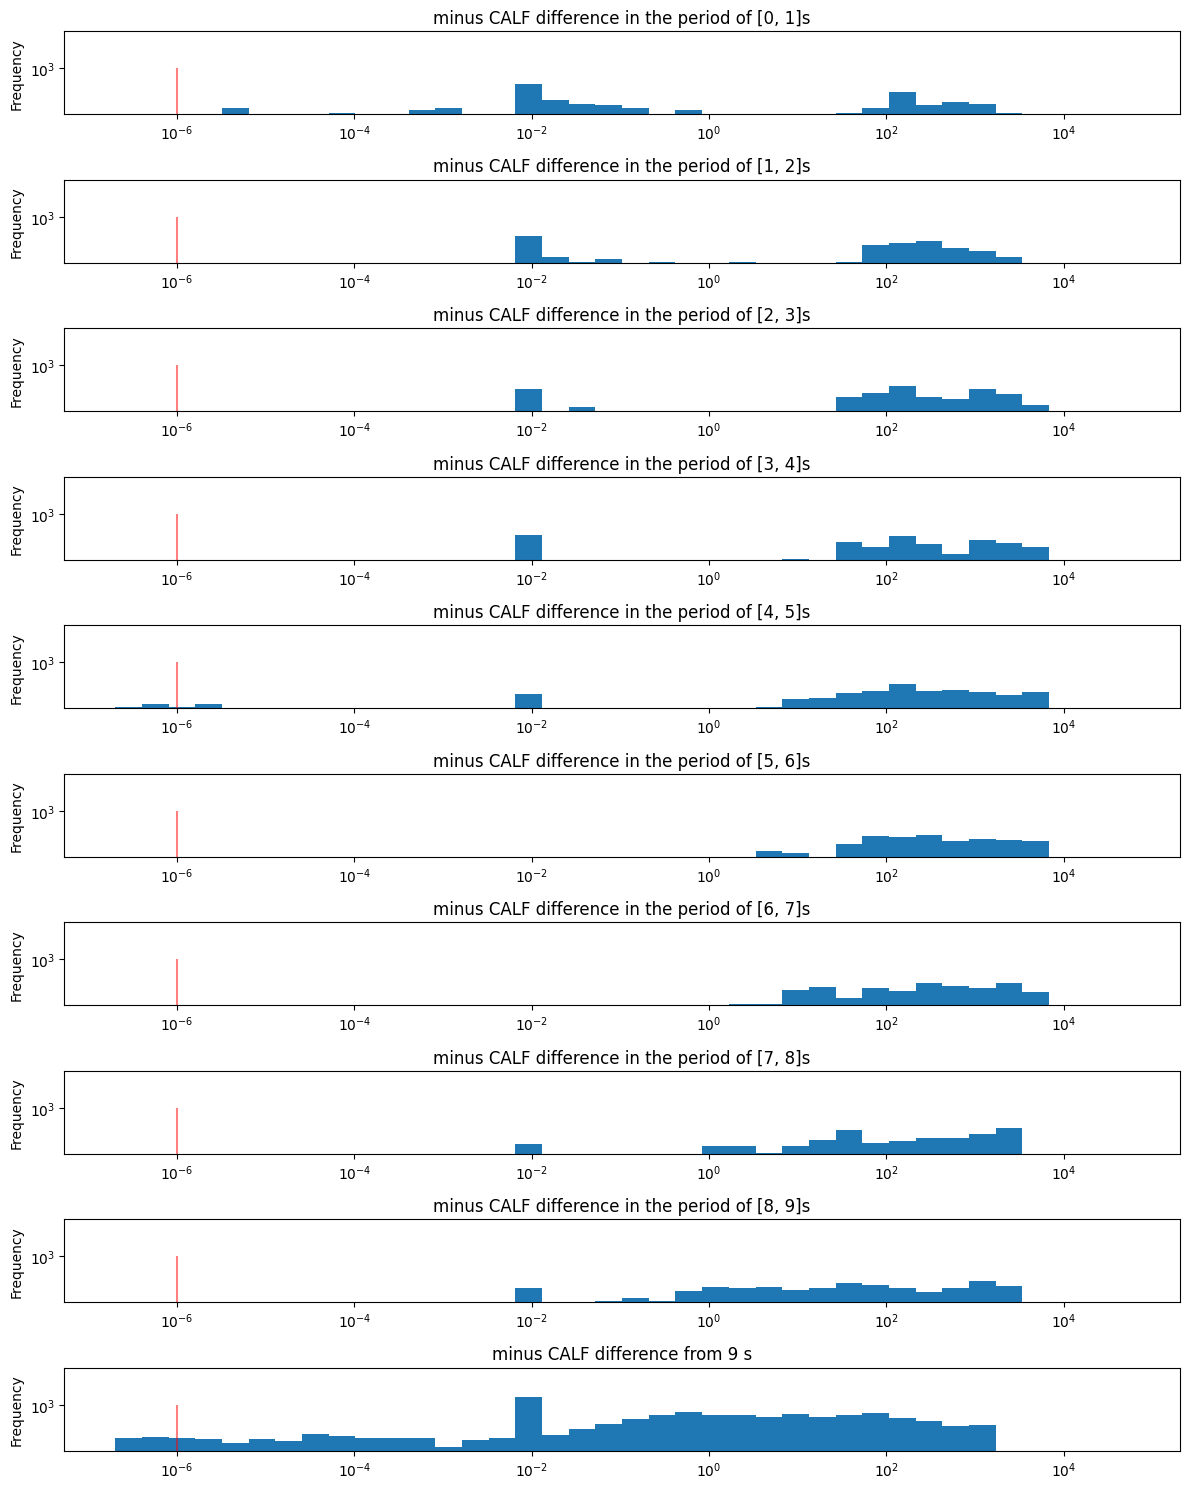

In [17]:
def plot_calf_in_time_slot(df):
    time_ranges = [i for i in range(10)]

    fig, ax = plt.subplots(len(time_ranges), 1, figsize=(12, 15), sharey=True)

    for time_index in range(1, len(time_ranges) + 1):
        if time_index < len(time_ranges):
            df_condition = np.logical_and(df.time < time_ranges[time_index],
                                        time_ranges[time_index - 1] <= df.time)
        else:
            df_condition = time_ranges[time_index - 1] <= df.time

        sub_df_1 = df[df_condition]
        
        # sub_df_1.calf_diff.plot(kind="hist", log=True, bins=500, ax=ax[0])
        ax[time_index - 1].vlines(x=- 1e-5 * 0.1, ymin=0, ymax=1e5, color="red", alpha=0.5)

        only_negative_calf_diff = sub_df_1.calf_diff[sub_df_1.calf_diff < 0]
        only_negative_calf_diff = -1 * only_negative_calf_diff

        range_calf_diff = [1e-7 * 2 ** i for i in range(1, 40)]
        range_calf_diff.sort()
        if np.max(range_calf_diff) < only_negative_calf_diff.max():
            range_calf_diff += [only_negative_calf_diff.max()] 

        only_negative_calf_diff.plot(kind="hist", log=True, bins=range_calf_diff, ax=ax[time_index - 1])
        # only_negative_calf_diff.plot(kind="hist", log=True, bins=500, ax=ax[1])

        ax[time_index - 1].vlines(x=1e-5 * 0.1, ymin=0, ymax=1e3, color="red", alpha=0.5)
        ax[time_index - 1].set_xscale('log')

        if time_index < len(time_ranges):
            ax[time_index - 1].set_title("minus CALF difference in the period of [{}, {}]s".format(
                time_ranges[time_index-1], time_ranges[time_index]
                ))
        else:
            ax[time_index - 1].set_title("minus CALF difference from {} s".format(
                time_ranges[time_index-1]
                ))

    plt.tight_layout()

plot_calf_in_time_slot(concat_df.copy())
concat_df.calf_diff.describe()

count    8822.000000
mean     -150.135832
std       518.421374
min     -4497.691887
25%       -31.259057
50%        -0.059927
75%        -0.010000
max        37.836447
Name: calf_diff, dtype: float64

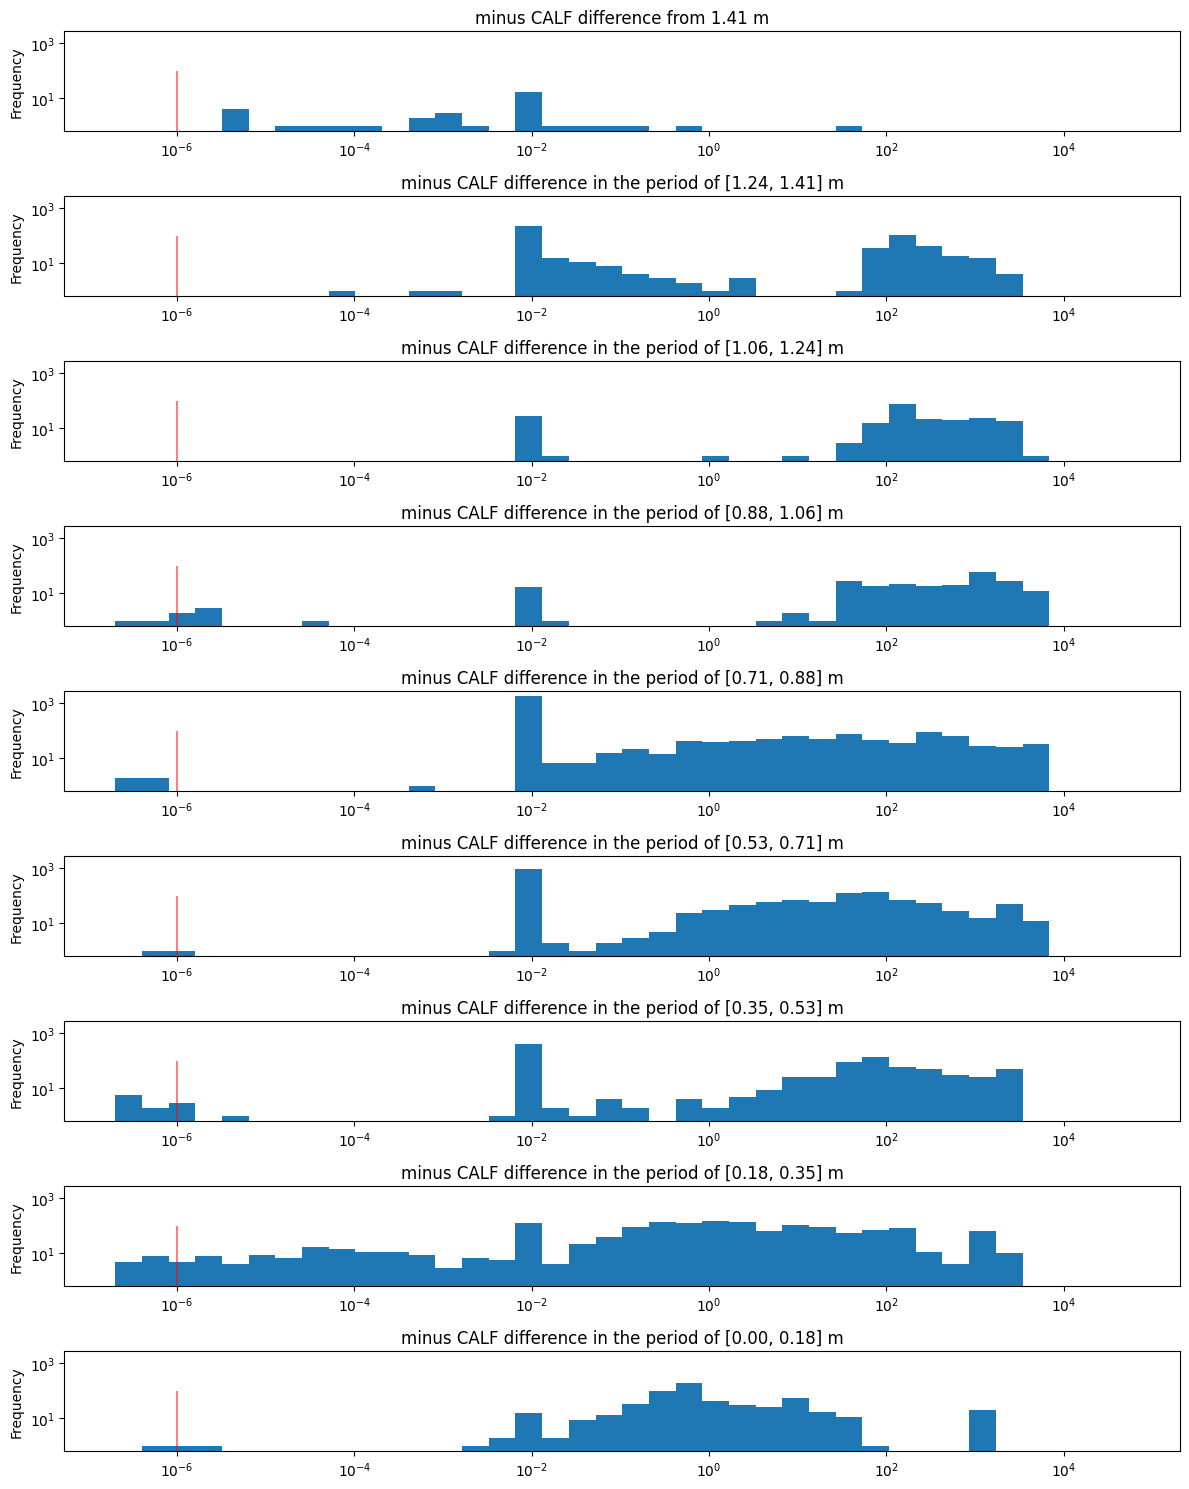

In [18]:
def plot_calf_in_distance_slot(df):
    position_range = np.linspace(0, np.sqrt(2), 9)

    fig, ax = plt.subplots(len(position_range), 1, figsize=(12, 15), sharey=True)

    for pos_index in range(1, len(position_range) + 1):
        if pos_index < len(position_range):
            df_condition = np.logical_and(df.dis_2_goal < position_range[pos_index],
                                        position_range[pos_index - 1] <= df.dis_2_goal)
        else:
            df_condition = position_range[pos_index - 1] <= df.dis_2_goal

        sub_df_1 = df[df_condition]
        
        only_negative_calf_diff = sub_df_1.calf_diff[sub_df_1.calf_diff < 0]
        only_negative_calf_diff = -1 * only_negative_calf_diff

        range_calf_diff = [1e-7 * 2 ** i for i in range(1, 40)]
        range_calf_diff.sort()
        
        if np.max(range_calf_diff) < only_negative_calf_diff.max():
            range_calf_diff += [only_negative_calf_diff.max()] 

        only_negative_calf_diff.plot(kind="hist", log=True, bins=range_calf_diff, ax=ax[len(position_range) - pos_index])
        # only_negative_calf_diff.plot(kind="hist", log=True, bins=500, ax=ax[1])

        ax[len(position_range) - pos_index].vlines(x=1e-5 * 0.1, ymin=0, ymax=1e2, color="red", alpha=0.5)
        ax[len(position_range) - pos_index].set_xscale('log')

        if pos_index < len(position_range):
            ax[len(position_range) - pos_index].set_title("minus CALF difference in the period of [{:.2f}, {:.2f}] m".format(
                position_range[pos_index-1], position_range[pos_index]
                ))
        else:
            ax[len(position_range) - pos_index].set_title("minus CALF difference from {:.2f} m".format(
                position_range[pos_index-1]
                ))
            

    plt.tight_layout()

plot_calf_in_distance_slot(concat_df.copy())
concat_df.calf_diff.describe()


# Choose best runs

In [19]:
# concat_df.loc[:, ["seed", "iteration_id", "current_value", "dis_2_goal"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value").head(10)

filter_on_target_df(concat_df)

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad],use_calf,critic_new,critic_safe,critic_low_kappa,critic_up_kappa,calf_diff,file_name,seed,dis_2_goal


In [20]:
import numpy as np

file_path = "regelum_data/outputs/2024-07-25/15-34-05/5/.callbacks/PolicyNumpyModelSaver/model_it_00008.npy"
np.load(file_path)

array([[840.77299884,  57.15768448,  69.26495025, 343.54587708,
        442.21957115, 615.59968761, 116.39389034, 205.24973822,
        225.25329311, 305.34649108, 753.57204667]])